#Import Data dari Google Drive dan Import Libraries yang akan digunakan pada project kali ini

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import re
import nltk
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_absolute_error, accuracy_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import datetime
import warnings
import sys

import warnings
warnings.filterwarnings("ignore")

# Set display options
pd.options.display.max_columns = None
pd.options.display.max_rows = 10

# Download stopwords list and wordnet
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
posting = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/lowongan_kerja.csv")

#detail_pekerjaan
benefit = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_pekerjaan/benefit.csv")
industri_pekerjaan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_pekerjaan/industri_pekerjaan.csv")
skill_pekerjaan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_pekerjaan/skill_pekerjaan.csv")
upah = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_pekerjaan/upah.csv")

#detail_perusahaan
industri_perusahaan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_perusahaan/industri_perusahaan.csv")
jumlah_karyawan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_perusahaan/jumlah_karyawan.csv")
perusahaan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_perusahaan/perusahaan.csv")
spesialisasi_perusahaan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/detail_perusahaan/spesialisasi_perusahaan.csv")

#mapping
industri = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/mapping/industri.csv")
kemampuan = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/mapping/kemampuan.csv")

#new
new = pd.read_csv("/content/drive/MyDrive/Datasets/dataset-6/linkedIn_posting/new.csv",sep='\t')

In [ ]:
#posting
posting.shape

(33246, 25)

In [ ]:
#detail_pekerjaan
print(benefit.shape)
print(industri_pekerjaan.shape)
print(skill_pekerjaan.shape)
print(upah.shape)

(29325, 3)
(44091, 2)
(56591, 2)
(13352, 8)


In [ ]:
#detail_perusahaan
print(industri_perusahaan.shape)
print(jumlah_karyawan.shape)
print(perusahaan.shape)
print(spesialisasi_perusahaan.shape)

(12601, 2)
(14275, 4)
(11361, 10)
(78405, 2)


In [ ]:
#mapping
print(industri.shape)
print(kemampuan.shape)

(229, 2)
(35, 2)


In [ ]:
#mapping
print(industri.shape)
print(kemampuan.shape)

(229, 2)
(35, 2)


#Memahami Karakteristik Dataset

##Posting Data

In [ ]:
posting.head()

,id_pekerjaan,id_perusahaan,judul,deskripsi,gaji_maksimal,gaji_tengah,gaji_minimal,periode_pembayaran,jenis_pekerjaan_terformat,lokasi,lamaran,diperbolehkan_jarak_jauh,tampilan,url_posting_pekerjaan,url_pendaftaran,tipe_pendaftaran,tingkat_pengalaman_terformat,deskripsi_keterampilan,domain_penyelenggaraan,disponsori,jenis_pekerjaan,mata_uang,tipe_kompensasi,waktu_kedaluwarsa,waktu_daftar
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,https://careers-demant.icims.com/jobs/19601/he...,OffsiteApply,Entry level,NaN,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 09:26:40
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,https://www.click2apply.net/mXLQz5S5NEYEXsKjwH...,OffsiteApply,NaN,NaN,www.click2apply.net,0,FULL_TIME,NaN,NaN,2023-12-04 08:53:20,2023-11-04 06:40:00
2,3757938019,474443.0,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,https://www.click2apply.net/LwbOykH2yAJdahB5Ah...,OffsiteApply,NaN,Bachelor's Degree in Mechanical Engineering pr...,www.click2apply.net,0,FULL_TIME,NaN,NaN,2023-12-04 08:53:20,2023-11-04 06:40:00
3,3757938018,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",NaN,NaN,1.0,https://www.linkedin.com/jobs/view/3757938018/...,https://jobs.apploi.com/view/854782?utm_campai...,OffsiteApply,Entry level,NaN,jobs.apploi.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 06:40:00
4,3757937095,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,NaN,1.0,NaN,https://www.linkedin.com/jobs/view/3757937095/...,https://careers.iherb.com/global/en/job/IHINGL...,OffsiteApply,Mid-Senior level,NaN,careers.iherb.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 09:26:40


In [ ]:
benefit.head()

,id_pekerjaan,benefit,jenis
0,3690843087,0,Medical insurance
1,3690843087,0,Dental insurance
2,3690843087,0,401(k)
3,3690843087,0,Paid maternity leave
4,3690843087,0,Disability insurance


In [ ]:
industri_pekerjaan.head()

,id_pekerjaan,id_industri
0,3378133231,68
1,3497509795,96
2,3690843087,47
3,3691775263,112
4,3691779379,80


In [ ]:
skill_pekerjaan.head()

,id_pekerjaan,singkatan_kemampuan
0,3690843087,ACCT
1,3690843087,FIN
2,3691763971,MGMT
3,3691763971,MNFC
4,3691775263,MGMT


In [ ]:
upah.head()

,id_gaji,id_pekerjaan,gaji_maksimal,gaji_median,gaji_minimal,periode_pembayaran,mata_uang,jenis_kompensasi
0,1,3378133231,30.0,NaN,22.0,HOURLY,USD,BASE_SALARY
1,2,3690843087,65000.0,NaN,55000.0,YEARLY,USD,BASE_SALARY
2,3,3691794313,22.0,NaN,19.0,HOURLY,USD,BASE_SALARY
3,4,3691795389,70000.0,NaN,68000.0,YEARLY,USD,BASE_SALARY
4,5,3691797089,22.0,NaN,18.0,HOURLY,USD,BASE_SALARY


##detail_perusahaan data

In [ ]:
industri_perusahaan.head()

,id_perusahaan,industri
0,81149246,Higher Education
1,10033339,Information Technology & Services
2,6049228,Accounting
3,2641066,Electrical & Electronic Manufacturing
4,96649998,Marketing & Advertising


In [ ]:
jumlah_karyawan.head()

,id_perusahaan,jumlah_karyawan,jumlah_follower,waktu_dicatat
0,81149246,6,91,1.692645e+09
1,10033339,3,187,1.692645e+09
2,6049228,20,82,1.692645e+09
3,2641066,45,2336,1.692645e+09
4,96649998,0,2,1.692645e+09


In [ ]:
perusahaan.head()

,id_perusahaan,nama,deskripsi,ukuran_perusahaan,negara_bagian,negara,kota,kode_pos,alamat,url
0,1009,IBM,"At IBM, we do more than work. We create. We cr...",7.0,NY,US,"Armonk, New York",10504,International Business Machines Corp.,https://www.linkedin.com/company/ibm
1,1016,GE HealthCare,Every day millions of people feel the impact o...,7.0,0,US,Chicago,0,-,https://www.linkedin.com/company/gehealthcare
2,1021,GE Power,"GE Power, part of GE Vernova, is a world energ...",7.0,NY,US,Schenectady,12345,1 River Road,https://www.linkedin.com/company/gepower
3,1025,Hewlett Packard Enterprise,Official LinkedIn of Hewlett Packard Enterpris...,7.0,Texas,US,Houston,77389,1701 E Mossy Oaks Rd Spring,https://www.linkedin.com/company/hewlett-packa...
4,1028,Oracle,We’re a cloud technology company that provides...,7.0,Texas,US,Austin,78741,2300 Oracle Way,https://www.linkedin.com/company/oracle


In [ ]:
spesialisasi_perusahaan.head()

,id_perusahaan,spesialisasi
0,81149246,Childrens Music Education
1,81149246,Foundational Music Theory
2,81149246,Child Music Lessons
3,81149246,social emotional learning
4,81149246,social emotional development


##mapping data

In [ ]:
industri.head()

,id_industri,nama_industri
0,1,Defense and Space Manufacturing
1,3,Computer Hardware Manufacturing
2,4,Software Development
3,5,Computer Networking Products
4,6,"Technology, Information and Internet"


In [ ]:
kemampuan.head()

,singkatan_kemampuan,nama_kemampuan
0,PRCH,Purchasing
1,SUPL,Supply Chain
2,PR,Public Relations
3,SCI,Science
4,STRA,Strategy/Planning


#Merging Data

###merge detail pekerjaan

Kami tidak memasukan Fitur 'upah' dikarenakan data upah(gaji) sudah ada dalam data 'posting'.

setelah kami cek fitur 'upah' tidak akan menambah informasi yang berguna.

In [ ]:
dfn = posting.copy()

dfn = pd.merge(dfn, benefit, on='id_pekerjaan', how='left')
dfn = pd.merge(dfn, industri_pekerjaan, on='id_pekerjaan', how='left')
dfn = pd.merge(dfn, skill_pekerjaan, on='id_pekerjaan', how='left')

# df = pd.merge(df, upah, on='id_pekerjaan', how='left')

###merge detail perusahaan

Kami juga tidak memasukan fitur 'spesialisasi_perusahaan' dikarenakan data bertambah menjadi sangat banyak

In [ ]:
dfn = pd.merge(dfn, industri_perusahaan, on='id_perusahaan', how='left')
dfn = pd.merge(dfn, jumlah_karyawan, on='id_perusahaan', how='left')
dfn = pd.merge(dfn, perusahaan, on='id_perusahaan', how='left')

#spesialisasi membuat data menjadi sangat besar, yaitu 3 juta lebih data
# dfn = pd.merge(dfn, spesialisasi_perusahaan, on='id_perusahaan', how='left')

###merge mapping

In [ ]:
dfn['id_industri'] = dfn['id_industri'].fillna(0)
dfn['id_industri'] = dfn['id_industri'].astype(int)

dfn['id_perusahaan'] = dfn['id_perusahaan'].fillna(0)
dfn['id_perusahaan'] = dfn['id_perusahaan'].astype(int)

In [ ]:
dfn = pd.merge(dfn, industri, on='id_industri', how='left')
dfn = pd.merge(dfn, kemampuan, on='singkatan_kemampuan', how='left')

#Overview data setelah proses merging

In [ ]:
dfn.head()

,id_pekerjaan,id_perusahaan,judul,deskripsi_x,gaji_maksimal,gaji_tengah,gaji_minimal,periode_pembayaran,jenis_pekerjaan_terformat,lokasi,lamaran,diperbolehkan_jarak_jauh,tampilan,url_posting_pekerjaan,url_pendaftaran,tipe_pendaftaran,tingkat_pengalaman_terformat,deskripsi_keterampilan,domain_penyelenggaraan,disponsori,jenis_pekerjaan,mata_uang,tipe_kompensasi,waktu_kedaluwarsa,waktu_daftar,benefit,jenis,id_industri,singkatan_kemampuan,industri,jumlah_karyawan,jumlah_follower,waktu_dicatat,nama,deskripsi_y,ukuran_perusahaan,negara_bagian,negara,kota,kode_pos,alamat,url,nama_industri,nama_kemampuan
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,https://careers-demant.icims.com/jobs/19601/he...,OffsiteApply,Entry level,NaN,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 09:26:40,1.0,Medical insurance,17,OTHR,Retail,1171.0,11417.0,1.699131e+09,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,Medical Equipment Manufacturing,Other
1,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",NaN,NaN,9.0,https://www.linkedin.com/jobs/view/3757940104/...,https://careers-demant.icims.com/jobs/19601/he...,OffsiteApply,Entry level,NaN,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 09:26:40,1.0,Disability insurance,17,OTHR,Retail,1171.0,11417.0,1.699131e+09,HearingLife,HearingLife is a national hearing care company...,5.0,New Jersey,US,Somerset,08873,580 Howard Avenue,https://www.linkedin.com/company/hearing-life,Medical Equipment Manufacturing,Other
2,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,https://www.click2apply.net/mXLQz5S5NEYEXsKjwH...,OffsiteApply,NaN,NaN,www.click2apply.net,0,FULL_TIME,NaN,NaN,2023-12-04 08:53:20,2023-11-04 06:40:00,NaN,NaN,135,MGMT,Industrial Machinery Manufacturing,300.0,2923.0,1.699085e+09,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,Industrial Machinery Manufacturing,Management
3,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757940025/...,https://www.click2apply.net/mXLQz5S5NEYEXsKjwH...,OffsiteApply,NaN,NaN,www.click2apply.net,0,FULL_TIME,NaN,NaN,2023-12-04 08:53:20,2023-11-04 06:40:00,NaN,NaN,135,MNFC,Industrial Machinery Manufacturing,300.0,2923.0,1.699085e+09,"Metalcraft of Mayville, Inc.","Headquartered in Mayville, Wisconsin, Metalcra...",4.0,WI,US,Mayville,53050,1000 Metalcraft Drive,https://www.linkedin.com/company/metalcraft-of...,Industrial Machinery Manufacturing,Manufacturing
4,3757938019,474443,"Manager, Engineering",\nThe TSUBAKI name is synonymous with excellen...,NaN,NaN,NaN,NaN,Full-time,"Bessemer, AL",NaN,NaN,NaN,https://www.linkedin.com/jobs/view/3757938019/...,https://www.click2apply.net/LwbOykH2yAJdahB5Ah...,OffsiteApply,NaN,Bachelor's Degree in Mechanical Engineering pr...,www.click2apply.net,0,FULL_TIME,NaN,NaN,2023-12-04 08:53:20,2023-11-04 06:40:00,NaN,NaN,147,ENG,Automation Machinery Manufacturing,314.0,8487.0,1.699086e+09,"U.S. Tsubaki Power Transmission, LLC","U.S. Tsubaki Power Transmission, LLC is a subs...",4.0,Illinois,US,Wheeling,60090,301E Marquardt Drive,https://www.linkedin.com/company/u.s.-tsubaki-...,Automation Machinery Manufacturing,Engineering


In [ ]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357529 entries, 0 to 357528
Data columns (total 44 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_pekerjaan                  357529 non-null  int64  
 1   id_perusahaan                 357529 non-null  int64  
 2   judul                         357529 non-null  object 
 3   deskripsi_x                   357521 non-null  object 
 4   gaji_maksimal                 165830 non-null  float64
 5   gaji_tengah                   20693 non-null   float64
 6   gaji_minimal                  165830 non-null  float64
 7   periode_pembayaran            186523 non-null  object 
 8   jenis_pekerjaan_terformat     357529 non-null  object 
 9   lokasi                        357529 non-null  object 
 10  lamaran                       204623 non-null  float64
 11  diperbolehkan_jarak_jauh      50066 non-null   float64
 12  tampilan                      300610 non-nul

Data bertambah dari yang awalnya mempunyai (**33246** baris dan **25** kolom) menjadi (**357529** baris dan **44** kolom) setelah proses merging


In [ ]:
print(dfn.shape)
print(posting.shape)

(357529, 44)
(33246, 25)


#Missing Value Check

In [ ]:
dfn.isna().sum().sort_values(ascending=False)

deskripsi_keterampilan      355569
gaji_tengah                 336836
diperbolehkan_jarak_jauh    307463
gaji_maksimal               191699
gaji_minimal                191699
                             ...  
waktu_daftar                     0
waktu_kedaluwarsa                0
id_perusahaan                    0
tipe_pendaftaran                 0
id_pekerjaan                     0
Length: 44, dtype: int64

melakukan drop pada data yang mempunyai missing value pada kolom 'gaji_minimal' atau 'gaji_maksimal', agar nantinya dapat membuat Kolom 'gaji_tengah' tanpa missing value.

In [ ]:
# Drop rows with missing values in 'gaji_minimum' and 'gaji_maksimal'
dfn = dfn.dropna(subset=['gaji_minimal', 'gaji_maksimal'])

# Print the shape of the DataFrame before and after dropping missing values
print("Shape after dropping missing values:", dfn.shape)

Shape after dropping missing values: (165830, 44)


drop gaji tengah

In [ ]:
dfn.drop(columns=['gaji_tengah'], inplace=True)

Mengisi missing value pada kolom 'deskripsi_keterampilan' menggunakan string 'NA'.

In [ ]:
dfn['deskripsi_keterampilan'] = dfn['deskripsi_keterampilan'].fillna('NA')

kolom 'diperbolehkan_jarak_jauh' hanya mempunyai nilai 1(boleh) dan 0(tidak)

oleh karena itu kami Mengisi missing value pada kolom 'diperbolehkan_jarak_jauh' menggunakan nilai 0.

karena setelah melakukan EDA kami menemukan bahwa nilai null pada kolom 'diperbolehkan_jarak_jauh' artinya itu sama dengan 0 (tidak) diperbolehkan bekerja secara jarak jauh.

In [ ]:
dfn['diperbolehkan_jarak_jauh'] = dfn['diperbolehkan_jarak_jauh'].fillna(0)

kolom 'benefit' hanya mempunyai nilai 1(mendapatkan) dan 0(tidak mendapatkan)

oleh karena itu kami Mengisi missing value pada kolom 'benefit' menggunakan nilai 0.

karena setelah melakukan EDA kami menemukan bahwa nilai null pada kolom 'benefit' artinya itu sama dengan 0(tidak mendapatkan) benefit.

In [ ]:
dfn['benefit'] = dfn['benefit'].fillna(0)

jenis adalah jenis benefit yang didapatkan.

Kami mengisi kolom 'jenis' menggunakan string 'NoBenefit' dikarenakan nilai null pada kolom 'jenis' menandakan tidak mendapatkan 'benefit' perusahaan.

In [ ]:
dfn['jenis'] = dfn['jenis'].fillna('NoBenefit')

drop semua data yang mempunyai missing value

In [ ]:
dfn.dropna(inplace = True)

jumlah baris dan kolom setelah melakukan drop missing value pada data

In [ ]:
print("Shape after dropping missing values:", dfn.shape)

Shape after dropping missing values: (22286, 43)


#Duplicate Data Check

Tidak ada nilai duplicate pada data.

tetapi memang nantinya akan banyak data yang sekilas terlihat duplicate padahal tidak.

In [ ]:
dfn[dfn.duplicated()]

,id_pekerjaan,id_perusahaan,judul,deskripsi_x,gaji_maksimal,gaji_minimal,periode_pembayaran,jenis_pekerjaan_terformat,lokasi,lamaran,diperbolehkan_jarak_jauh,tampilan,url_posting_pekerjaan,url_pendaftaran,tipe_pendaftaran,tingkat_pengalaman_terformat,deskripsi_keterampilan,domain_penyelenggaraan,disponsori,jenis_pekerjaan,mata_uang,tipe_kompensasi,waktu_kedaluwarsa,waktu_daftar,benefit,jenis,id_industri,singkatan_kemampuan,industri,jumlah_karyawan,jumlah_follower,waktu_dicatat,nama,deskripsi_y,ukuran_perusahaan,negara_bagian,negara,kota,kode_pos,alamat,url,nama_industri,nama_kemampuan


#Feature Engineering

###Membuat fitur baru 'golongan_followers' menggunakan quartil untuk pembagian golongan followers dari data 'jumlah_follower'.

In [ ]:
q1 = dfn['jumlah_follower'].quantile(0.25)
q2 = dfn['jumlah_follower'].quantile(0.75)
q3 = dfn['jumlah_follower'].max()

In [ ]:
print(q1)
print(q2)
print(q3)

83345.75
2120713.0
31887198.0


In [ ]:
# Tentukan persentil
q1 = dfn['jumlah_follower'].quantile(0.25)
q2 = dfn['jumlah_follower'].quantile(0.75)

def categorize_followers(follower_count):
    if follower_count <= q1:
        return 'kecil'
    elif q1 < follower_count <= q2:
        return 'sedang'
    else:
        return 'besar'

dfn['golongan_followers'] = dfn['jumlah_follower'].apply(categorize_followers)
dfn['golongan_followers'] = dfn['golongan_followers'].astype('object')

In [ ]:
dfn['golongan_followers'].value_counts()

golongan_followers
sedang    11281
kecil      5572
besar      5433
Name: count, dtype: int64

###Membuat fitur baru 'nama_negara' dari kolom 'negara' yang berisi singkatan nama negara, agar mempermudah melakukan analisis nantinya.

In [ ]:
# Mendefinisikan kode negara
country_mapping = {
    'US': 'United States',
    'IE': 'Ireland',
    'OO': '?',
    'DE': 'Germany',
    'GB': 'United Kingdom',
    'SE': 'Sweden',
    'NL': 'Netherlands',
    'JP': 'Japan',
    'FR': 'France',
    'IN': 'India',
    'CH': 'Switzerland',
    'CA': 'Canada',
    'DK': 'Denmark',
    'AU': 'Australia',
    'CN': 'China',
    'BE': 'Belgium',
    'NO': 'Norway',
    '0': '-',
    'ES': 'Spain',
    'FI': 'Finland',
    'SA': 'Saudi Arabia',
    'TW': 'Taiwan',
    'IL': 'Israel',
    'IT': 'Italy',
    'SG': 'Singapore',
    'MX': 'Mexico',
    'HK': 'Hong Kong',
    'AT': 'Austria',
    'BM': 'Bermuda',
    'IS': 'Iceland',
    'LI': 'Liechtenstein',
    'MT': 'Malta',
    'AE': 'United Arab Emirates',
    'LU': 'Luxembourg',
    'NZ': 'New Zealand',
    'HU': 'Hungary',
    'RU': 'Russia',
    'KR': 'Korea',
    'KE': 'Kenya',
    'EE': 'Estonia',
    'CO': 'Colombia',
    'PR': 'Puerto Rico',
    'PH': 'Philippines',
    'MD': 'Replublic of Moldova',
    'GE': 'Georgia',
    'ID': 'Indonesia',
    'BR': 'Brazil',
    'CZ': 'Czechia',
    'TR': 'Turkey',
    'HR': 'Croatia',
    'KY': 'Cayman Islands',
    'VN': 'Vietnam	',
    'AZ': 'Azerbaijan',
    'UY': 'Uruguay',
    'VG': 'Virgin Islands',
    'AR': 'Argentina'
}

# Menggunakan 'map' untuk menambahkan kolom baru berdasarkan kode negara
dfn['nama_negara'] = dfn['negara'].map(country_mapping)

###Melakukan konversi semua gaji menjadi gaji Tahunan agar saat melakukan analisis gaji semuanya dalam rentang 'periode_pembayaran' yang sama.

Drop Column 'periode_pembayaran' yang bayaran nya per project karena itu tidak sesuai untuk analisis kami kali ini.

In [ ]:
dfn = dfn[dfn['periode_pembayaran'] != 'ONCE']

In [ ]:
dfn['periode_pembayaran'].value_counts()

periode_pembayaran
YEARLY     18815
HOURLY      3316
MONTHLY      155
Name: count, dtype: int64

In [ ]:
dfn[dfn['periode_pembayaran'] == 'HOURLY'].head(1)

,id_pekerjaan,id_perusahaan,judul,deskripsi_x,gaji_maksimal,gaji_minimal,periode_pembayaran,jenis_pekerjaan_terformat,lokasi,lamaran,diperbolehkan_jarak_jauh,tampilan,url_posting_pekerjaan,url_pendaftaran,tipe_pendaftaran,tingkat_pengalaman_terformat,deskripsi_keterampilan,domain_penyelenggaraan,disponsori,jenis_pekerjaan,mata_uang,tipe_kompensasi,waktu_kedaluwarsa,waktu_daftar,benefit,jenis,id_industri,singkatan_kemampuan,industri,jumlah_karyawan,jumlah_follower,waktu_dicatat,nama,deskripsi_y,ukuran_perusahaan,negara_bagian,negara,kota,kode_pos,alamat,url,nama_industri,nama_kemampuan,golongan_followers,nama_negara
276,3757932846,10515052,Estimator In Training,Company: Gerber Collision & Glass\n\nWELCOME T...,20.0,14.0,HOURLY,Full-time,"Marietta, GA",1.0,0.0,2.0,https://www.linkedin.com/jobs/view/3757932846/...,https://boydgroup.wd1.myworkdayjobs.com/boydca...,OffsiteApply,Mid-Senior level,NA,boydgroup.wd1.myworkdayjobs.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 06:40:00,1.0,401(k),3198,MGMT,Motor Vehicle Manufacturing,244.0,3203.0,1.699072e+09,Boyd Group Services Inc.,Boyd Group Services Inc. (”BGSI”) is a Canadia...,6.0,Manitoba,CA,Winnipeg,R3H 1A6,1745 Ellice Ave,https://www.linkedin.com/company/the-boyd-grou...,Automotive,Management,kecil,Canada


In [ ]:
def convert_to_yearly(row):

    if row['periode_pembayaran'] == 'MONTHLY':
        return row['gaji_minimal'] * 12, row['gaji_maksimal'] * 12
    elif row['periode_pembayaran'] == 'WEEKLY':
        return row['gaji_minimal'] * 52, row['gaji_maksimal'] * 52
    elif row['periode_pembayaran'] == 'HOURLY':
        return row['gaji_minimal'] * 2080, row['gaji_maksimal'] * 2080
    else:
        return row['gaji_minimal'], row['gaji_maksimal']

dfn['gaji_minimal'], dfn['gaji_maksimal'] = zip(*dfn.apply(convert_to_yearly, axis=1))

In [ ]:
# Buat kolom baru 'gaji_tengah' dengan nilai median dari 'gaji_minimal' dan 'gaji_maksimal'
dfn['gaji_tengah'] = (dfn['gaji_minimal'] + dfn['gaji_maksimal']) / 2

In [ ]:
dfn[dfn['id_pekerjaan'] == 3757932846].head(1)

,id_pekerjaan,id_perusahaan,judul,deskripsi_x,gaji_maksimal,gaji_minimal,periode_pembayaran,jenis_pekerjaan_terformat,lokasi,lamaran,diperbolehkan_jarak_jauh,tampilan,url_posting_pekerjaan,url_pendaftaran,tipe_pendaftaran,tingkat_pengalaman_terformat,deskripsi_keterampilan,domain_penyelenggaraan,disponsori,jenis_pekerjaan,mata_uang,tipe_kompensasi,waktu_kedaluwarsa,waktu_daftar,benefit,jenis,id_industri,singkatan_kemampuan,industri,jumlah_karyawan,jumlah_follower,waktu_dicatat,nama,deskripsi_y,ukuran_perusahaan,negara_bagian,negara,kota,kode_pos,alamat,url,nama_industri,nama_kemampuan,golongan_followers,nama_negara,gaji_tengah
276,3757932846,10515052,Estimator In Training,Company: Gerber Collision & Glass\n\nWELCOME T...,41600.0,29120.0,HOURLY,Full-time,"Marietta, GA",1.0,0.0,2.0,https://www.linkedin.com/jobs/view/3757932846/...,https://boydgroup.wd1.myworkdayjobs.com/boydca...,OffsiteApply,Mid-Senior level,NA,boydgroup.wd1.myworkdayjobs.com,0,FULL_TIME,USD,BASE_SALARY,2023-12-04 08:53:20,2023-11-04 06:40:00,1.0,401(k),3198,MGMT,Motor Vehicle Manufacturing,244.0,3203.0,1.699072e+09,Boyd Group Services Inc.,Boyd Group Services Inc. (”BGSI”) is a Canadia...,6.0,Manitoba,CA,Winnipeg,R3H 1A6,1745 Ellice Ave,https://www.linkedin.com/company/the-boyd-grou...,Automotive,Management,kecil,Canada,35360.0


In [ ]:
# Buat dictionary untuk mengganti nilai unik dengan 'HOURLY'
mapping = {periode_pembayaran: 'YEARLY' for periode_pembayaran in dfn['periode_pembayaran'].unique()}

dfn['periode_pembayaran'] = dfn['periode_pembayaran'].replace(mapping)

###membuat fitur baru 'golongan_gaji' dengan 4 kategori:
- below : dibawah dari rata-rata gaji
- average : rata-rata gaji
- above average : diatas rata-rata gaji
- excelent : kategori gaji sangat besar

In [ ]:
dfn = dfn[dfn['gaji_tengah'] < 450000]

In [ ]:
below = dfn['gaji_tengah'].quantile(0.25).astype(int)
avg = dfn['gaji_tengah'].mean().astype(int)
above_avg =  dfn['gaji_tengah'].quantile(0.75).astype(int)
excelent = dfn['gaji_tengah'].max().astype(int)

print(below)
print(avg)
print(above_avg)
print(excelent)

76577
122522
168000
400000


In [ ]:
below = dfn['gaji_tengah'].quantile(0.25).astype(int)
avg = dfn['gaji_tengah'].mean().astype(int)
above_avg =  dfn['gaji_tengah'].quantile(0.75).astype(int)

def categorize_salary(salary):
    if salary <= below:
        return 'below'
    elif below < salary <= avg:
        return 'average'
    elif avg < salary <= above_avg:
        return 'above_average'
    else:
        return 'excelent'

dfn['golongan_gaji'] = dfn['gaji_tengah'].apply(categorize_salary)
dfn['golongan_gaji'] = dfn['golongan_gaji'].astype('object')

###Membuat Fitur Ratio Gaji dengan Biaya Hidup

In [ ]:
# Definisi biaya hidup bulanan (estimasi)
biaya_hidup = {
    'United States': 3500*12,
    'Ireland': 3200*12,
    'Germany': 2500*12,
    'United Kingdom': 3200*12,
    'Sweden': 2800*12,
    'Netherlands': 3000*12,
    'Japan': 2800*12,
    'France': 2800*12,
    'India': 600*12,
    'Switzerland': 4000*12,
    'Canada': 3000*12,
    'Denmark': 3100*12,
    'Australia': 3100*12,
    'China': 1500*12,
    'Belgium': 2900*12,
    'Norway': 3200*12,
    'Spain': 2000*12,
    'Finland': 2700*12,
    'Saudi Arabia': 2500*12,
    'Taiwan': 2000*12,
    'Israel': 2900*12,
    'Italy': 2500*12,
    'Singapore': 3500*12,
    'Mexico': 1200*12,
    'Hong Kong': 3500*12,
    'Austria': 2700*12,
    'Bermuda': 4500*12,
    'Iceland': 3500*12,
    'Liechtenstein': 3500*12,
    'Malta': 2000*12,
    'United Arab Emirates': 2700*12,
    'Luxembourg': 3000*12,
    'New Zealand': 3000*12,
    'Hungary': 1600*12,
    'Russia': 1200*12,
    'Korea': 2500*12,
    'Kenya': 1000*12,
    'Estonia': 1800*12,
    'Colombia': 1200*12,
    'Puerto Rico': 2500*12,
    'Philippines': 1000*12,
    'Republic of Moldova': 800*12,
    'Georgia': 1000*12,
    'Indonesia': 700*12,
    'Brazil': 900*12,
    'Czechia': 1700*12,
    'Turkey': 1200*12,
    'Croatia': 1500*12,
    'Cayman Islands': 4500*12,
    'Vietnam': 800*12,
    'Azerbaijan': 1000*12,
    'Uruguay': 2000*12,
    'Virgin Islands': 3500*12,
    'Argentina': 900*12
}

In [ ]:
# Menggunakan 'map' untuk menambahkan kolom biaya hidup
dfn['biaya_hidup'] = dfn['nama_negara'].map(biaya_hidup)

# Menghitung rasio gaji terhadap biaya hidup
dfn['rasio_gaji_biaya_hidup'] = dfn['gaji_tengah'] / dfn['biaya_hidup']

##Membuat kategori Industri yang lebih besar

In [ ]:
industry_to_big_category = {
    'Automotive': 'Automotive',
    'Travel Arrangements': 'Travel and Tourism',
    'Motor Vehicle Manufacturing': 'Automotive',
    'Biotechnology Research': 'Biotechnology',
    'Financial Services': 'Finance',
    'Food and Beverage Manufacturing': 'Food and Beverage',
    'Hospitals and Health Care': 'Healthcare',
    'IT Services and IT Consulting': 'IT',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Telecommunications': 'Telecommunications',
    'Defense and Space Manufacturing': 'Defense and Aerospace',
    'Wholesale Building Materials': 'Wholesale',
    'Sporting Goods Manufacturing': 'Sports and Recreation',
    'Computer Hardware Manufacturing': 'IT',
    'Software Development': 'IT',
    'Computers and Electronics Manufacturing': 'IT',
    'Furniture and Home Furnishings Manufacturing': 'Home and Garden',
    'Retail Apparel and Fashion': 'Retail',
    'Machinery Manufacturing': 'Manufacturing',
    'Entertainment Providers': 'Entertainment',
    'Hospitality': 'Hospitality',
    'Non-profit Organizations': 'Non-profit',
    'Education Administration Programs': 'Education',
    'Spectator Sports': 'Sports and Recreation',
    'Government Administration': 'Government',
    'Insurance': 'Finance',
    'Staffing and Recruiting': 'Human Resources',
    'Accounting': 'Finance',
    'Retail': 'Retail',
    'Research Services': 'Research',
    'Chemical Manufacturing': 'Chemicals',
    'Civil Engineering': 'Engineering',
    'Construction': 'Construction',
    'Truck Transportation': 'Transportation and Logistics',
    'Manufacturing': 'Manufacturing',
    'Investment Management': 'Finance',
    'Banking': 'Finance',
    'Wellness and Fitness Services': 'Healthcare',
    'Medical Practices': 'Healthcare',
    'Leasing Non-residential Real Estate': 'Real Estate',
    'Technology, Information and Internet': 'IT',
    'Law Practice': 'Legal',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Business Consulting and Services': 'Consulting',
    'Marketing Services': 'Marketing',
    'Performing Arts': 'Arts and Culture',
    'Computer Networking Products': 'IT',
    'E-Learning Providers': 'Education',
    'Newspaper Publishing': 'Media',
    'Medical Equipment Manufacturing': 'Healthcare',
    'Residential Building Construction': 'Construction',
    'Real Estate': 'Real Estate',
    'Information Services': 'IT',
    'Pharmaceutical Manufacturing': 'Healthcare',
    'Advertising Services': 'Marketing',
    'Restaurants': 'Food and Beverage',
    'Consumer Goods': 'Retail',
    'Higher Education': 'Education',
    'Renewable Energy Semiconductor Manufacturing': 'Renewable Energy',
    'Renewable Energy Power Generation': 'Renewable Energy',
    'Computer and Network Security': 'IT',
    'Primary and Secondary Education': 'Education',
    'Food and Beverage Services': 'Food and Beverage',
    'Cosmetics': 'Beauty',
    'Human Resources Services': 'Human Resources',
    'Environmental Services': 'Environment',
    'Data Security Software Products': 'IT',
    'Internet Marketplace Platforms': 'IT',
    'Gambling Facilities and Casinos': 'Gaming',
    'Online Audio and Video Media': 'Media',
    'Facilities Services': 'Services',
    'Research': 'Research',
    'Aviation and Aerospace Component Manufacturing': 'Aerospace',
    'Appliances, Electrical, and Electronics Manufacturing': 'IT',
    'Public Safety': 'Government',
    'Equipment Rental Services': 'Services',
    'Renewable Energy Equipment Manufacturing': 'Renewable Energy',
    'Book and Periodical Publishing': 'Media',
    'Computer Games': 'Gaming',
    'Architecture and Planning': 'Architecture',
    'Semiconductor Manufacturing': 'IT',
    'Broadcast Media Production and Distribution': 'Media',
    'Media Production': 'Media',
    'Legal Services': 'Legal',
    'Capital Markets': 'Finance',
    'Individual and Family Services': 'Services',
    'Airlines and Aviation': 'Aviation',
    'Security and Investigations': 'Security',
    'Mental Health Care': 'Healthcare',
    'Professional Services': 'Services',
    'Design Services': 'Design',
    'Education Management': 'Education',
    'Wholesale': 'Wholesale',
    'Retail Luxury Goods and Jewelry': 'Retail',
    'Utilities': 'Utilities',
    'Events Services': 'Events',
    'Economic Programs': 'Government',
    'Veterinary Services': 'Animal Care',
    'Internet Publishing': 'Media',
    'Museums, Historical Sites, and Zoos': 'Culture',
    'Consumer Services': 'Services',
    'Beverage Manufacturing': 'Food and Beverage',
    'Religious Institutions': 'Religion',
    'Retail Office Equipment': 'Retail',
    'Biotechnology': 'Biotechnology',
    'Market Research': 'Market Research',
    'Plastics Manufacturing': 'Plastics',
    'Education': 'Education',
    'Wireless Services': 'Telecommunications',
    'Electric Power Transmission, Control, and Distribution': 'Utilities',
    'Information Technology & Services': 'IT',
    'Defense & Space': 'Defense and Aerospace',
    'Ground Passenger Transportation': 'Transportation and Logistics',
    'Administration of Justice': 'Government',
    'Electric Power Generation': 'Utilities',
    'Public Relations and Communications Services': 'Marketing',
    'Artists and Writers': 'Arts and Culture',
    'Photography': 'Media',
    'Dentists': 'Healthcare',
    'Personal Care Product Manufacturing': 'Beauty',
    'Investment Banking': 'Finance',
    'International Trade and Development': 'Trade',
    'Outsourcing and Offshoring Consulting': 'Consulting',
    'Glass, Ceramics and Concrete Manufacturing': 'Construction Materials',
    'Mining': 'Mining',
    'Transportation/Trucking/Railroad': 'Transportation and Logistics',
    'Oil and Gas': 'Energy',
    'Food Production': 'Food and Beverage',
    'Veterinary': 'Animal Care',
    'Public Policy Offices': 'Government',
    'Urban Transit Services': 'Transportation and Logistics',
    'Human Resources': 'Human Resources',
    'Nanotechnology Research': 'Technology',
    'Automation Machinery Manufacturing': 'Manufacturing',
    'Retail Art Supplies': 'Retail',
    'Retail Groceries': 'Retail',
    'Food & Beverages': 'Food and Beverage',
    'Aviation & Aerospace': 'Aviation',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Rail Transportation': 'Transportation and Logistics',
    'Entertainment': 'Entertainment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics'
}
dfn['big_industry'] = dfn['nama_industri'].map(industry_to_big_category)

In [ ]:
def group_industry(industry):
    if industry in ['Transportation and Logistics', 'Aerospace', 'Aviation']:
        return 'Transportation'
    elif industry in ['Travel and Tourism', 'Hospitality']:
        return 'Travel & Hospitality'
    elif industry in ['Biotechnology', 'Healthcare', 'Pharmaceuticals']:
        return 'Healthcare & Pharmaceuticals'
    elif industry in ['IT', 'Telecommunications', 'Technology']:
        return 'Technology'
    elif industry in ['Defense and Aerospace', 'Security']:
        return 'Defense & Security'
    elif industry in ['Retail', 'Wholesale']:
        return 'Retail & Wholesale'
    elif industry in ['Manufacturing', 'Engineering', 'Construction', 'Construction Materials']:
        return 'Manufacturing & Construction'
    elif industry in ['Entertainment', 'Media', 'Gaming', 'Arts and Culture']:
        return 'Entertainment & Media'
    elif industry in ['Education', 'Human Resources', 'Research', 'Training']:
        return 'Education & Training'
    elif industry in ['Renewable Energy', 'Energy', 'Utilities']:
        return 'Energy & Utilities'
    elif industry in ['Beauty', 'Health & Wellness']:
        return 'Beauty & Wellness'
    elif industry in ['Architecture', 'Design']:
        return 'Design & Architecture'
    elif industry in ['Home and Garden', 'Real Estate']:
        return 'Real Estate & Home'
    elif industry in ['Sports and Recreation', 'Events']:
        return 'Sports & Events'
    elif industry in ['Non-profit', 'Religion']:
        return 'Non-profit & Religion'
    elif industry in ['Marketing', 'Advertising']:
        return 'Marketing & Advertising'
    elif industry in ['Plastics', 'Chemicals']:
        return 'Chemicals & Plastics'
    else:
        return industry

# Apply grouping function to create 'industry_large' column
dfn['industry'] = dfn['big_industry'].apply(group_industry)

##Membuat tingkat pengalaman menjadi lebih sedikit, agar mempermudah modeling dan analisis

In [ ]:
# Mengubah nilai-nilai dalam kolom 'tingkat_pengalaman'
dfn['tingkat_pengalaman_terformat'] = dfn['tingkat_pengalaman_terformat'].replace({
    'Mid-Senior level': 'Experienced',
    'Entry level': 'Junior',
    'Internship': 'Junior',
    'Associate': 'Junior',
    'Director': 'Manager',
    'Executive': 'Manager'
})

##Membuat Course online yang cocok untuk pada pencari pekerjaan, sesuai dengan industri nya.

In [ ]:
industry_courses = {
    'Automotive': 'Electric Cars: Introduction to Electric Powertrain by Delft University of Technology (Coursera)',
    'Travel & Hospitality': 'Hospitality and Tourism Management by University of Maryland (edX)',
    'Healthcare & Pharmaceuticals': 'Healthcare Marketplace Specialization by University of Minnesota (Coursera)',
    'Finance': 'Financial Markets by Yale University (Coursera)',
    'Food and Beverage': 'Nutrition and Health: Food Safety by Wageningen University & Research (edX)',
    'Technology': 'Introduction to Programming for Beginners (Udacity)',
    'Transportation': 'Supply Chain Management by MIT (edX)',
    'Defense & Security': 'Cybersecurity Specialization by University of Maryland (Coursera)',
    'Retail & Wholesale': 'Business of Retail: Operations & Marketing by The Wharton School, University of Pennsylvania (Coursera)',
    'Sports & Events': 'Sports Marketing by Northwestern University (Coursera)',
    'Real Estate & Home': 'Real Estate Economics and Finance by London School of Economics (edX)',
    'Manufacturing & Construction': 'Construction Management Specialization by Columbia University (Coursera)',
    'Entertainment & Media': 'Creative Writing Specialization by Wesleyan University (Coursera)',
    'Non-profit & Religion': 'Nonprofit Essentials by University of Notre Dame (edX)',
    'Education & Training': 'Learning How to Learn by McMaster University and University of California San Diego (Coursera)',
    'Government': 'Public Policy Challenges of the 21st Century by University of Virginia (Coursera)',
    'Chemicals & Plastics': 'Materials Science: 10 Things Every Engineer Should Know by University of California, Davis (Coursera)',
    'Legal': 'Contract Law: From Trust to Promise to Contract by Harvard University (edX)',
    'Consulting': 'Business Strategy Specialization by University of Virginia (Coursera)',
    'Marketing & Advertising': 'Digital Marketing Specialization by University of Illinois at Urbana-Champaign (Coursera)',
    'Energy & Utilities': 'Solar Energy by Delft University of Technology (edX)',
    'Beauty & Wellness': 'Complete Skin Care and Cosmetic Treatment Course (Udemy)',
    'Environment': 'Introduction to Environmental Law and Policy by University of North Carolina at Chapel Hill (Coursera)',
    'Services': 'Operations Management by University of Illinois at Urbana-Champaign (Coursera)',
    'Design & Architecture': 'Making Architecture by IE School of Architecture & Design (Coursera)',
    'Animal Care': 'Animal Behaviour and Welfare by University of Edinburgh (Coursera)',
    'Culture': 'Cultural Competence by University of Illinois at Urbana-Champaign (Coursera)',
    'Market Research': 'Market Research and Consumer Behavior by IE Business School (Coursera)',
    'Trade': 'International Business Management by IIM Bangalore (edX)',
    'Mining': 'Mining Engineering by Curtin University (edX)'
}

dfn['course'] = dfn['industry'].map(industry_courses)

#Membuat Data Baru dengan fitur-fitur yang sudah dipilih

In [ ]:
#jenis_pekerjaan tidak dibutuhkan karena sama dengan jenis_pekerjaan_terformat dan industri sama dengan nama_industri

df = dfn[['id_perusahaan', 'id_pekerjaan', 'nama', 'nama_industri', 'judul',
          'jenis_pekerjaan_terformat', 'tingkat_pengalaman_terformat', 'gaji_minimal',
          'gaji_tengah', 'gaji_maksimal', 'golongan_gaji', 'periode_pembayaran', 'rasio_gaji_biaya_hidup','mata_uang', 'diperbolehkan_jarak_jauh',
          'tipe_pendaftaran','tipe_kompensasi', 'benefit', 'jenis', 'ukuran_perusahaan',
          'jumlah_karyawan', 'jumlah_follower', 'golongan_followers','disponsori','deskripsi_keterampilan',
          'singkatan_kemampuan', 'nama_kemampuan', 'deskripsi_x','deskripsi_y','nama_negara','negara_bagian','kota','lokasi','tampilan',
          'industry', 'big_industry','course']]

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.rename(columns={'nama': 'nama_perusahaan', 'jenis': 'jenis_benefit', 'tampilan' : 'jumlah_tampilan'}, inplace=True)

In [ ]:
df.head()

,id_perusahaan,id_pekerjaan,nama_perusahaan,nama_industri,judul,jenis_pekerjaan_terformat,tingkat_pengalaman_terformat,gaji_minimal,gaji_tengah,gaji_maksimal,golongan_gaji,periode_pembayaran,rasio_gaji_biaya_hidup,mata_uang,diperbolehkan_jarak_jauh,tipe_pendaftaran,tipe_kompensasi,benefit,jenis_benefit,ukuran_perusahaan,jumlah_karyawan,jumlah_follower,golongan_followers,disponsori,deskripsi_keterampilan,singkatan_kemampuan,nama_kemampuan,deskripsi_x,deskripsi_y,nama_negara,negara_bagian,kota,lokasi,jumlah_tampilan,industry,big_industry,course
276,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,401(k),6.0,244.0,3203.0,kecil,0,NA,MGMT,Management,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...
277,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,401(k),6.0,244.0,3203.0,kecil,0,NA,MNFC,Manufacturing,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...
278,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,Vision insurance,6.0,244.0,3203.0,kecil,0,NA,MGMT,Management,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...
279,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,Vision insurance,6.0,244.0,3203.0,kecil,0,NA,MNFC,Manufacturing,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...
280,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,Disability insurance,6.0,244.0,3203.0,kecil,0,NA,MGMT,Management,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...


#EDA

In [ ]:
print("Data Awal                           : ",posting.shape)
print("Data setelah Proses Merging         : ",dfn.shape)
print("Data setelah proses pemilihan fitur : ",df.shape)

Data Awal                           :  (33246, 25)
Data setelah Proses Merging         :  (22220, 52)
Data setelah proses pemilihan fitur :  (22062, 37)


In [ ]:
df.describe()

,id_perusahaan,id_pekerjaan,gaji_minimal,gaji_tengah,gaji_maksimal,rasio_gaji_biaya_hidup,diperbolehkan_jarak_jauh,benefit,ukuran_perusahaan,jumlah_karyawan,jumlah_follower,disponsori,jumlah_tampilan
count,2.206200e+04,2.206200e+04,22062.000000,22062.000000,22062.000000,22062.000000,22062.000000,22062.000000,22062.000000,22062.000000,2.206200e+04,22062.000000,22062.000000
mean,5.393609e+06,3.717250e+09,95792.523830,122792.092548,149791.661267,2.942376,0.171698,0.474798,5.862478,134132.738646,6.509194e+06,0.262216,91.120751
std,1.496955e+07,2.791999e+07,44873.263397,57907.486065,75848.551213,1.396352,0.377126,0.499376,1.441024,262030.306210,1.154854e+07,0.439849,151.346349
min,1.016000e+03,3.689687e+09,13500.000000,16781.500000,20063.000000,0.399560,0.000000,0.000000,1.000000,12.000000,1.820000e+02,0.000000,1.000000
25%,1.586000e+03,3.697362e+09,61400.000000,76960.000000,89800.000000,1.841667,0.000000,0.000000,5.000000,2774.000000,8.420900e+04,0.000000,14.000000
50%,1.609400e+04,3.699085e+09,88000.000000,110150.000000,133000.000000,2.651190,0.000000,0.000000,7.000000,10095.000000,5.642990e+05,0.000000,40.000000
75%,2.355182e+06,3.755587e+09,124500.000000,168000.000000,205000.000000,4.000000,0.000000,1.000000,7.000000,71507.750000,2.120713e+06,1.000000,110.000000
max,1.007464e+08,3.757933e+09,350000.000000,400000.000000,500000.000000,9.523810,1.000000,1.000000,7.000000,829111.000000,3.188720e+07,1.000000,2131.000000


In [ ]:
# Hitung jumlah baris unik pada kolom 'ID'
jumlah_pekerjaan  = df['id_pekerjaan'].nunique()
jumlah_perusahaan = df['id_perusahaan'].nunique()

print("Jumlah Pekerjaan:", jumlah_pekerjaan)
print("Jumlah Perusahaan:", jumlah_perusahaan)

Jumlah Pekerjaan: 1887
Jumlah Perusahaan: 913


In [ ]:
jumlah_amazon = df['id_perusahaan'].value_counts().get(1586, 0)
jumlah_google = df['id_perusahaan'].value_counts().get(1441, 0)

print("Jumlah loker Amazon:", jumlah_amazon)
print("Jumlah loker Google:", jumlah_google)

Jumlah loker Amazon: 2640
Jumlah loker Google: 1440


#EDA LANJUTAN

Setelah melakukan Univariate Analysis dan Multivariate Analysis, ini adalah hasil analisis yang sejalan dengan goals project kami

##Distribusi Gaji

Gaji tengah paling banyak ditawarkan untuk range 50000-100000 USD

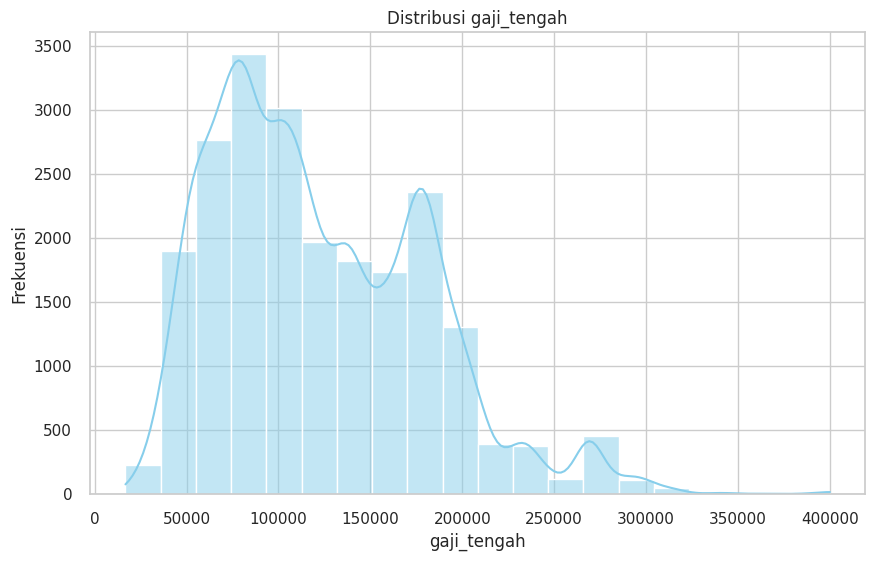

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['gaji_tengah'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi gaji_tengah')
plt.xlabel('gaji_tengah')
plt.ylabel('Frekuensi')
plt.show()

##Membuat Function untuk keperluan EDA

In [ ]:
def univariate_plot(df, nama_kolom, jumlah_top=15):
    nama_perusahaan = df[nama_kolom].value_counts().head(jumlah_top)
    total_data = len(df)

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x=nama_perusahaan.index, y=nama_perusahaan.values)

    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.,
                height + 0.5,
                '{:.2f}%'.format((height / total_data) * 100),
                ha="center")

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_salary(df, column_name):
    mean_salary_by_column = df.groupby(column_name)['gaji_tengah'].mean().sort_values(ascending=False)
    top_categories = mean_salary_by_column.head(15).index
    filtered_df = df[df[column_name].isin(top_categories)]
    filtered_df[column_name] = pd.Categorical(filtered_df[column_name], categories=top_categories, ordered=True)
    # Create the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=filtered_df, x=column_name, y="gaji_tengah", estimator='mean', ci=None, order=top_categories)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'AVG Salary by {column_name.capitalize()}')
    plt.xlabel(column_name.capitalize())
    plt.ylabel('Average Salary')
    plt.tight_layout()
    # Adding average salary values above each bar
    for p in ax.patches:
        ax.annotate(f'${p.get_height():.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')
    plt.show()

##Perusahaan apa yang paling banyak membuka lowongan pekerjaan

Amazon, Google, dan Jobot merupakan perusahaan yang membuka lowongan pekerjaan terbanyak.

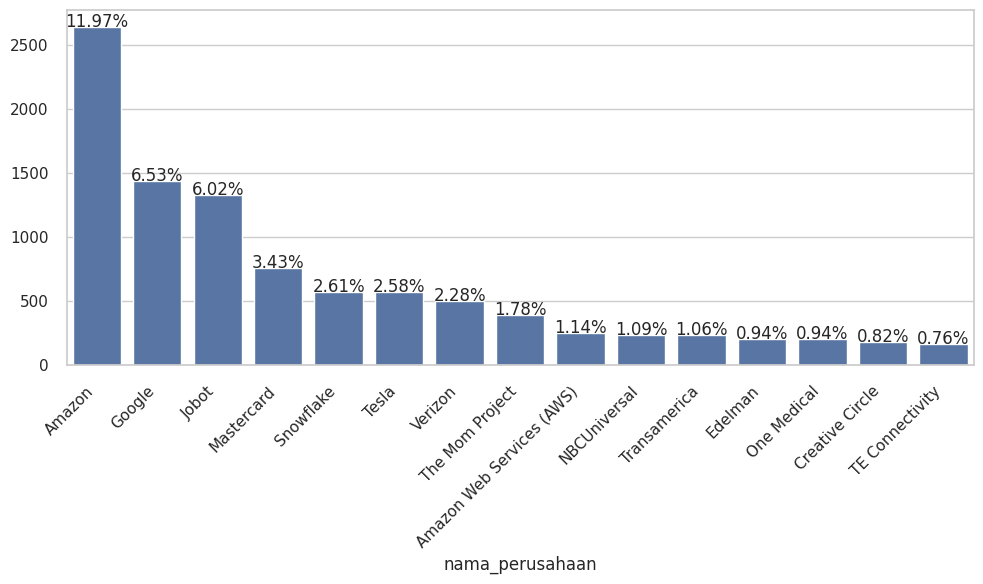

In [ ]:
univariate_plot(df, 'nama_perusahaan')

**Tingkat pengalaman terformat yang dibutuhkan oleh 3 perusahaan dengan lowongan pekerjaan terbanyak**

Amazon paling banyak mencari mid-senior, juga mencari director dan internship; Google paling banyak mencari mid-senior dan juga mencari director; sementara Jobot paling banyak mencari entry level dan mid-senior, serta mencari director. Sehingga yang paling banyak dibutuhkan oleh ketiga perusahaan dengan lowongan pekerjaan terbanyak adalah mid-senior dan director

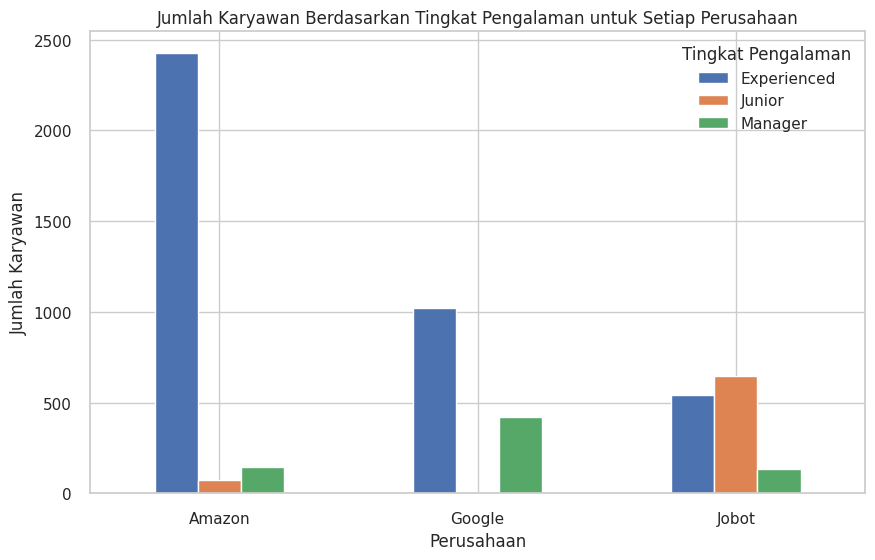

In [ ]:
perusahaan = ['Google', 'Amazon', 'Jobot']
df_lowongan = df[df['nama_perusahaan'].isin(perusahaan)]

df_baru = df[df['nama_perusahaan'].isin(perusahaan)]
grouped = df_baru.groupby(['nama_perusahaan', 'tingkat_pengalaman_terformat']).size().unstack(fill_value=0)

# Plotting barchart
grouped.plot(kind='bar', figsize=(10, 6))
plt.title('Jumlah Karyawan Berdasarkan Tingkat Pengalaman untuk Setiap Perusahaan')
plt.xlabel('Perusahaan')
plt.ylabel('Jumlah Karyawan')
plt.xticks(rotation=0)
plt.legend(title='Tingkat Pengalaman')
plt.show()

**Rata-Rata gaji yang ditawarkan 3 perusahaan dengan lowongan pekerjaan terbanyak**

Amazon menawarkan rata-rata gaji sebesar 139210 USD, Google menawarkan rata-rata gaji sebesar 211854 USD, sedangkan Jobot menawarkan gaji rata-rata sebsesar 103031 USD. Sehingga Google merupakan perushaan dengan lowongan pekerjaan terbanyak yang menawarkan rata-rata gaji tertinggi.

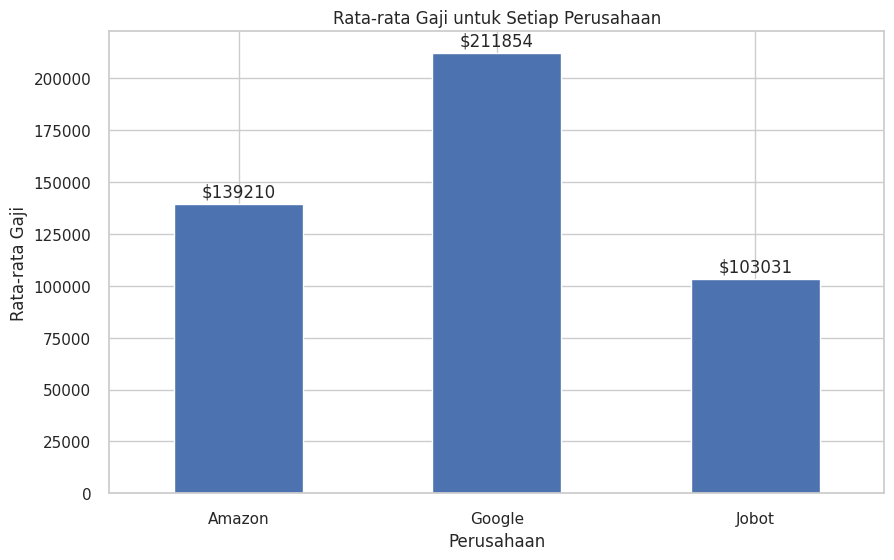

In [ ]:
average_salary = df_baru.groupby('nama_perusahaan')['gaji_tengah'].mean()

# Plotting barchart
ax = average_salary.plot(kind='bar', figsize=(10, 6))

# Menambahkan judul dan label
plt.title('Rata-rata Gaji untuk Setiap Perusahaan')
plt.xlabel('Perusahaan')
plt.ylabel('Rata-rata Gaji')
plt.xticks(rotation=0)

# Menambahkan label di atas setiap barchart
for i in ax.containers:
    ax.bar_label(i, label_type='edge', fmt='$%d', padding=3)

# Menampilkan plot
plt.show()

##Bidang industri yang memiliki prospek yang menjanjikan berdasarkan jumlah lowongan pekerjaan dan gaji

Industri dengan lowongan pekerjaan terbanyak adalah technology, information and internet; software development; dan IT service and IT consulting. Ketiga bidang tersebut termasuk dalam bidang Information Technology (IT), sehingga industri dengan lowongan pekerjaan terbanyak adalah IT.

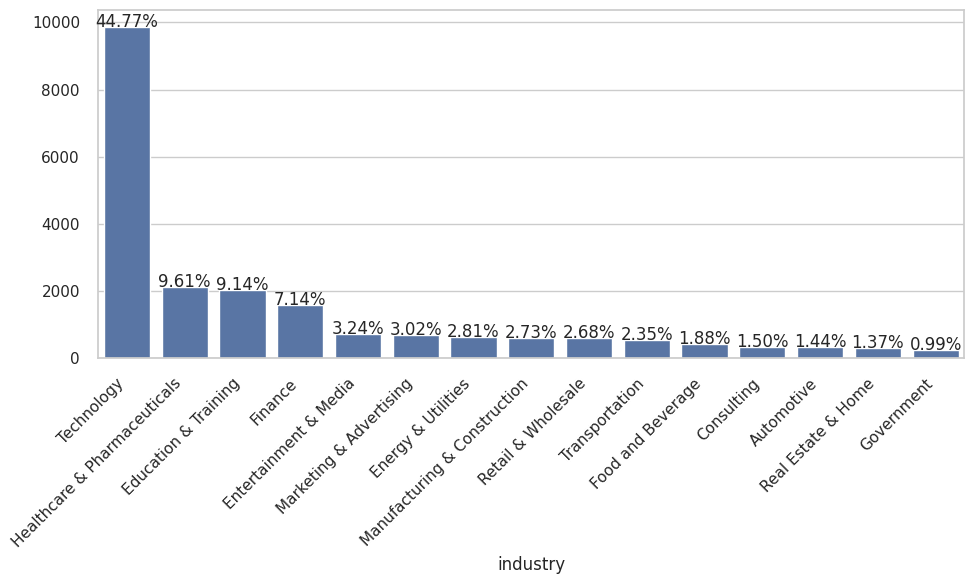

In [ ]:
univariate_plot(df, 'industry')

**Berapa rata-rata gaji yang ditawarkan untuk 3 industri yang paling dibutuhkan?**

Rata-rata gaji di industri IT Services and IT Consulting sebesar 124.645 USD, di Software Development sebesar 147.154 USD, dan di Technology, Information, and Internet sebesar 156.696 USD. Oleh karena itu, Technology, Information, and Internet adalah industri dengan lowongan pekerjaan terbanyak yang menawarkan rata-rata gaji tertinggi.

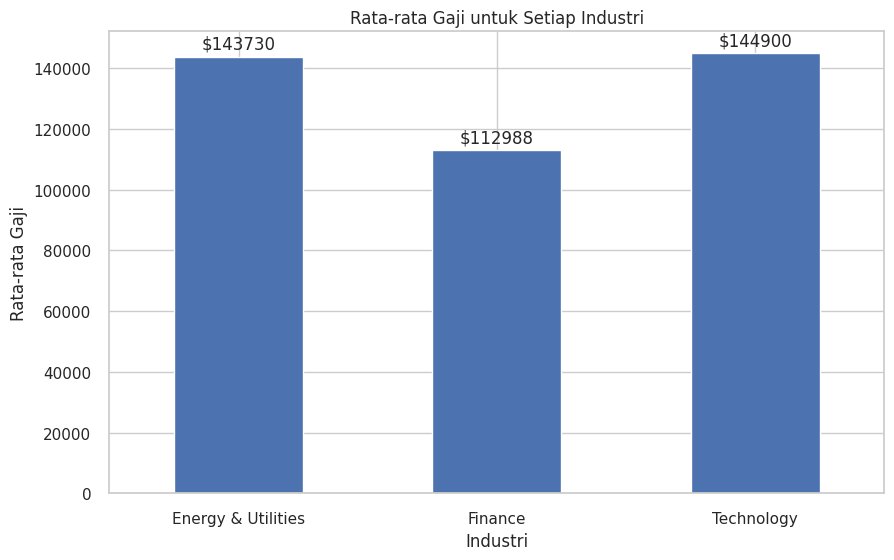

In [ ]:
industri = ['Technology', 'Energy & Utilities', 'Finance']
df_industri = df[df['industry'].isin(industri)]

average_salary_industry = df_industri.groupby('industry')['gaji_tengah'].mean()

# Plotting barchart
fig, ax = plt.subplots(figsize=(10, 6))
average_salary_industry.plot(kind='bar', ax=ax)
plt.title('Rata-rata Gaji untuk Setiap Industri')
plt.xlabel('Industri')
plt.ylabel('Rata-rata Gaji')
plt.xticks(rotation=0)

# Menambahkan label di atas setiap barchart
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='$%d', padding=3)

plt.show()

Hal ini sejalan dengan kemampuan yang paling dibutuhkan pun di bidang IT, Engineering, dan Sales.

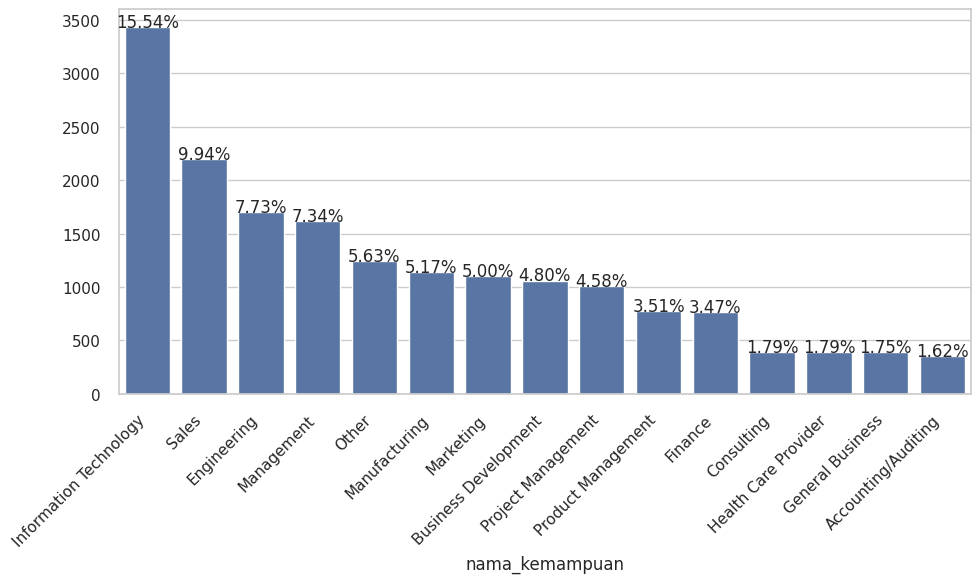

In [ ]:
univariate_plot(df, 'nama_kemampuan')

##Bidang Industri dengan Prospek Gaji Tertinggi

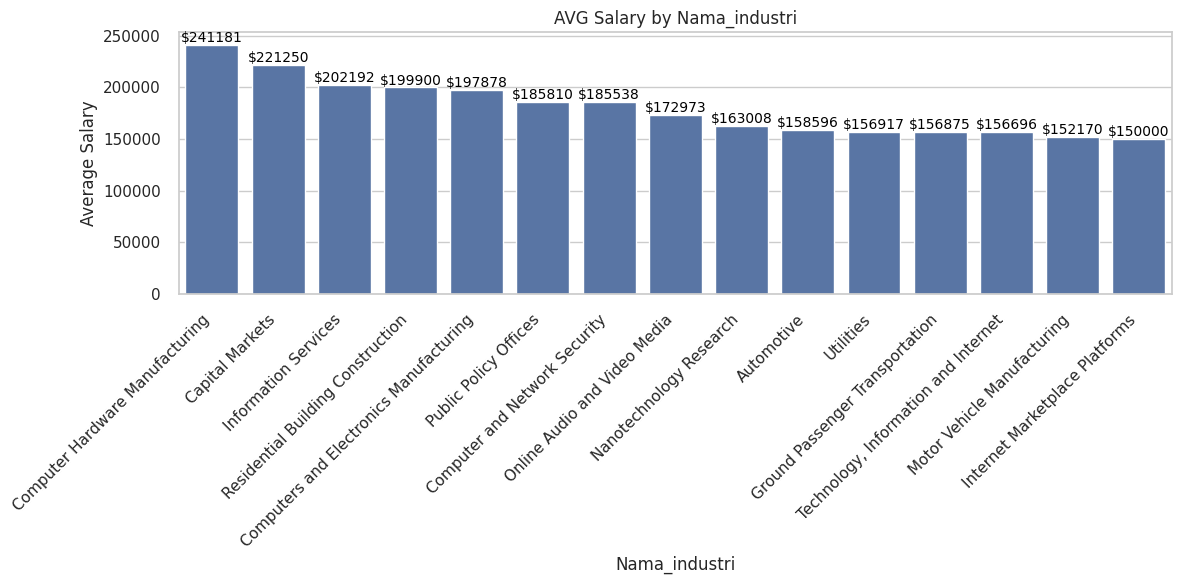

In [ ]:
plot_salary(df, 'nama_industri')

##Pengaruh pemberian Benefit dari Perusahaan terhadap Gaji Karyawan

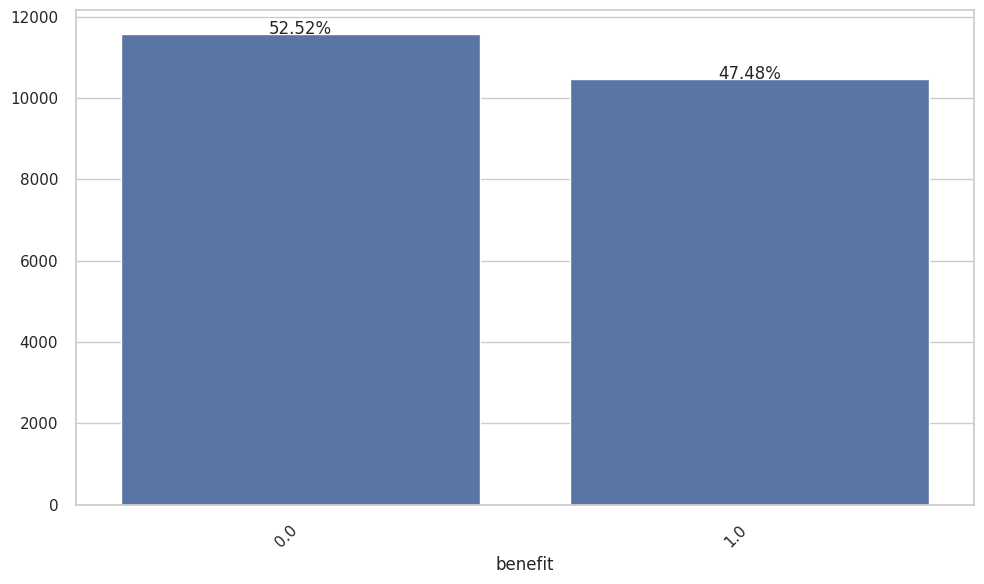

In [ ]:
univariate_plot(df, 'benefit')


Lebih banyak lowongan pekerjaan yang tidak menawarkan benefit dibandingkan yang menawarkan.

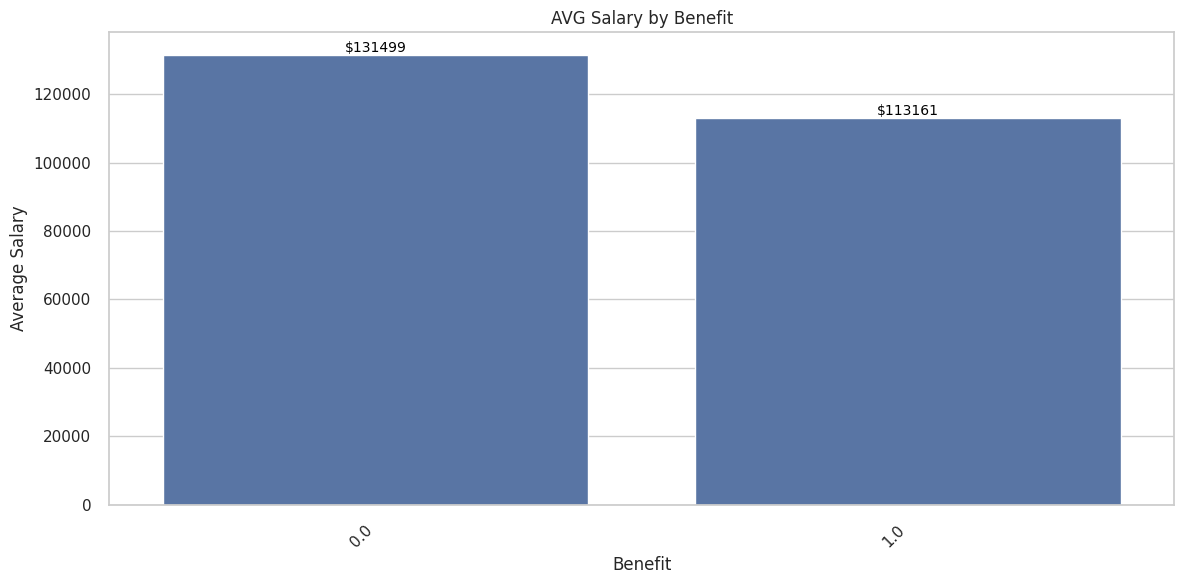

In [ ]:
plot_salary(df, 'benefit')

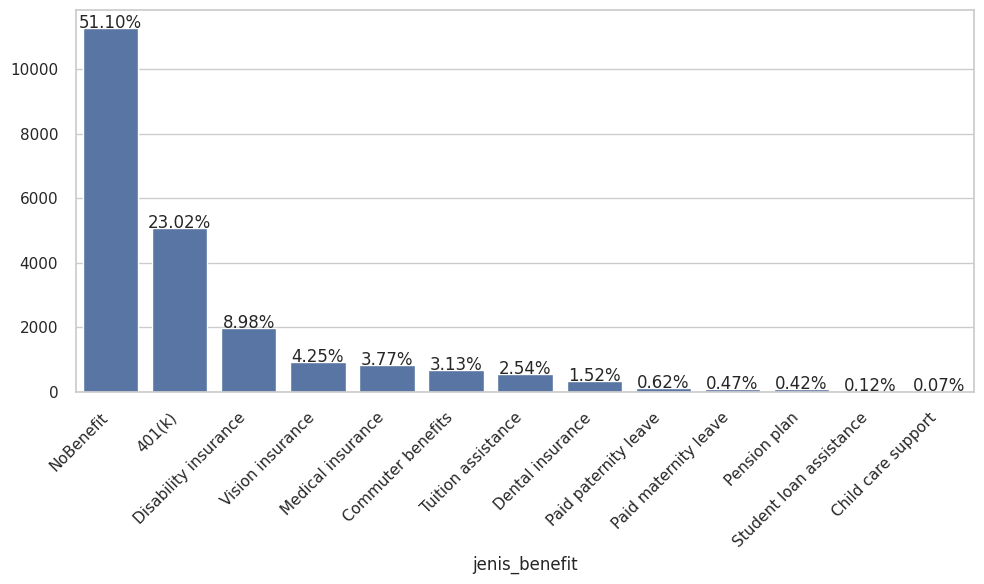

In [ ]:
univariate_plot(df, 'jenis_benefit')

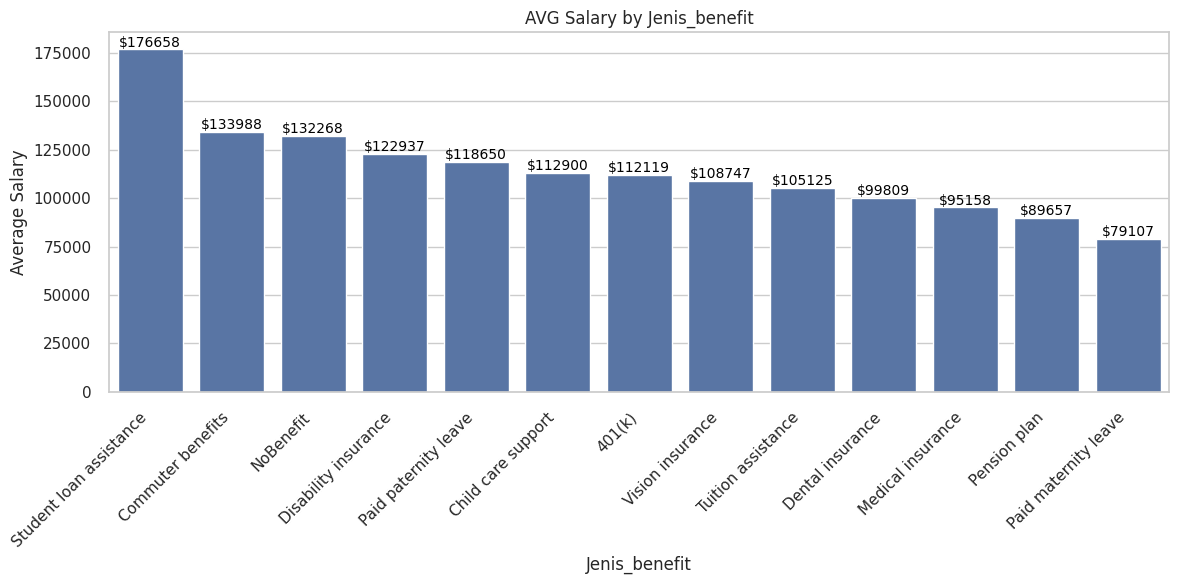

In [ ]:
plot_salary(df, 'jenis_benefit')

##Apakah Pekerjaan yang diperbolehkan Bekerja dari Jarak Jauh memiliki pengaruh terhadap Gaji Karyawan?

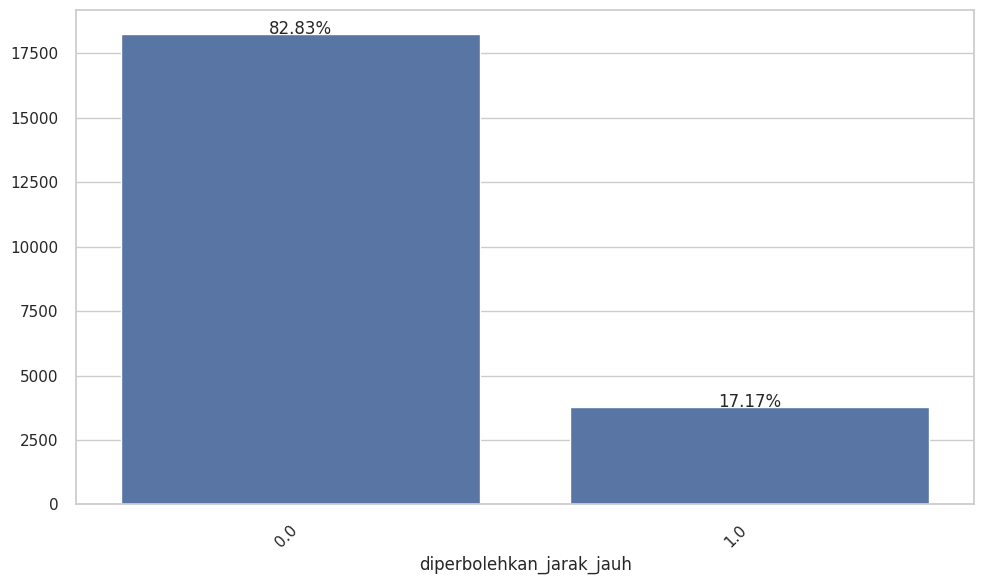

In [ ]:
univariate_plot(df, 'diperbolehkan_jarak_jauh')

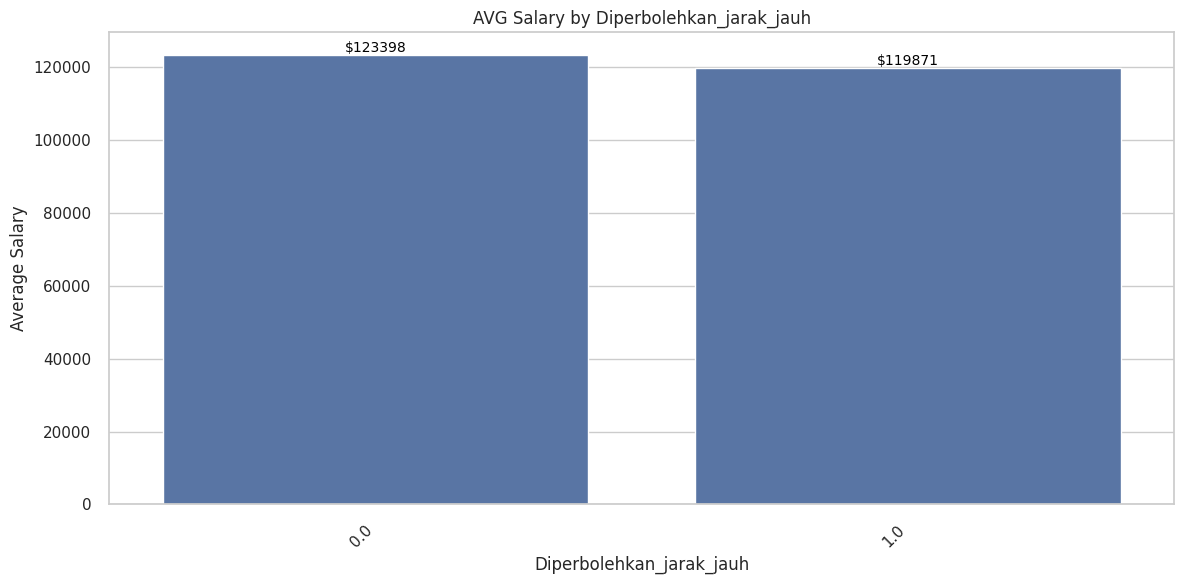

In [ ]:
plot_salary(df,'diperbolehkan_jarak_jauh')

##Pengaruh Ukuran Perusahaan

pengaruh ukuran perusahaan dengan jumlah lowongan kerja

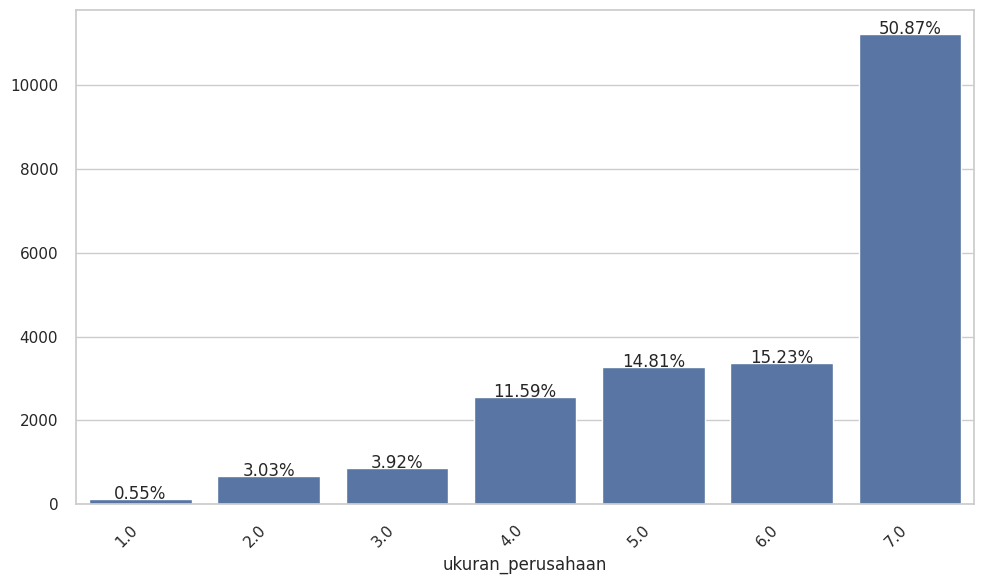

In [ ]:
univariate_plot(df, 'ukuran_perusahaan')

pengaruh ukuran perusahaan dengan jumlah Karyawan

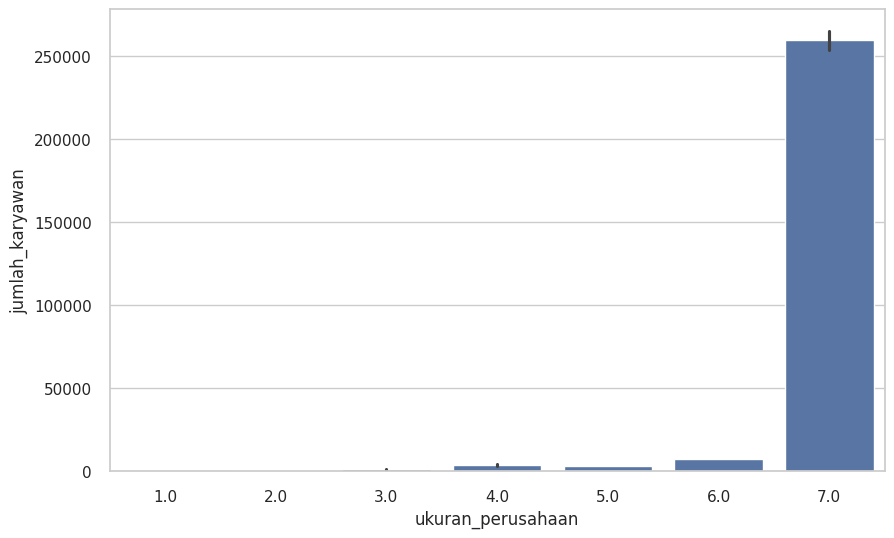

In [ ]:
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df, x='ukuran_perusahaan', y='jumlah_karyawan')

pengaruh ukuran perusahaan dengan jumlah Followers

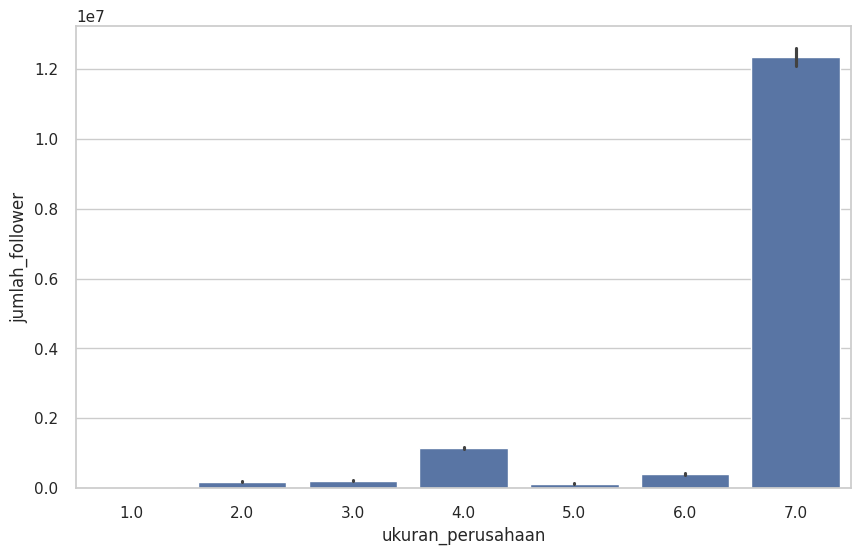

In [ ]:
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df, x='ukuran_perusahaan', y='jumlah_follower')

##Kemampuan apa yang paling banyak dibutuhkan saat ini dan Kemampuan apa yang memiliki gaji terbesar?

Kemampuan yang paling banyak dibutuhkan

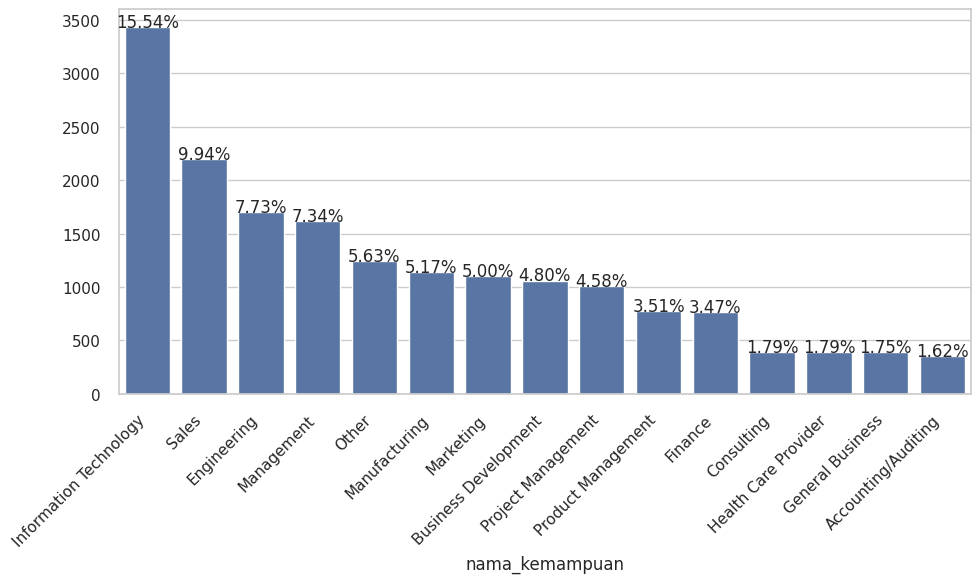

In [ ]:
univariate_plot(df, 'nama_kemampuan')

Rata-Rata Gaji dari Kemampuan yang paling dibutuhkan saat ini.

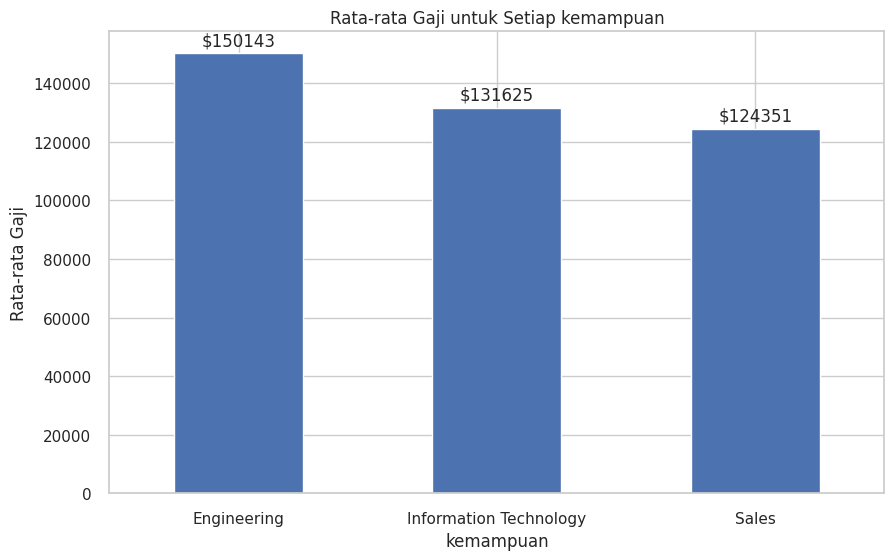

In [ ]:
kemampuan = ['Information Technology', 'Sales', 'Engineering']
df_kemampuan = df[df['nama_kemampuan'].isin(kemampuan)]

average_salary_skills = df_kemampuan.groupby('nama_kemampuan')['gaji_tengah'].mean()

# Plotting barchart
fig, ax = plt.subplots(figsize=(10, 6))
average_salary_skills.plot(kind='bar', ax=ax)
plt.title('Rata-rata Gaji untuk Setiap kemampuan')
plt.xlabel('kemampuan')
plt.ylabel('Rata-rata Gaji')
plt.xticks(rotation=0)

# Menambahkan label di atas setiap barchart
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fmt='$%d', padding=3)

plt.show()

Kemampuan dengan Gaji Tertinggi

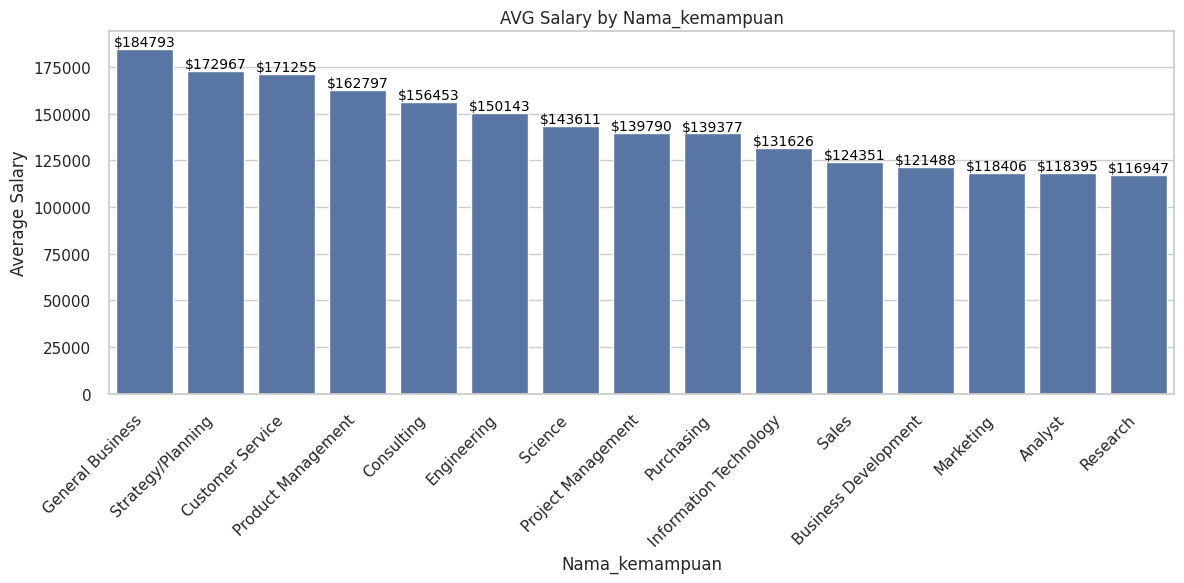

In [ ]:
plot_salary(df, 'nama_kemampuan')

##Negara Dengan Gaji Tertinggi dan Ratio Gaji dengan Biaya Hidup

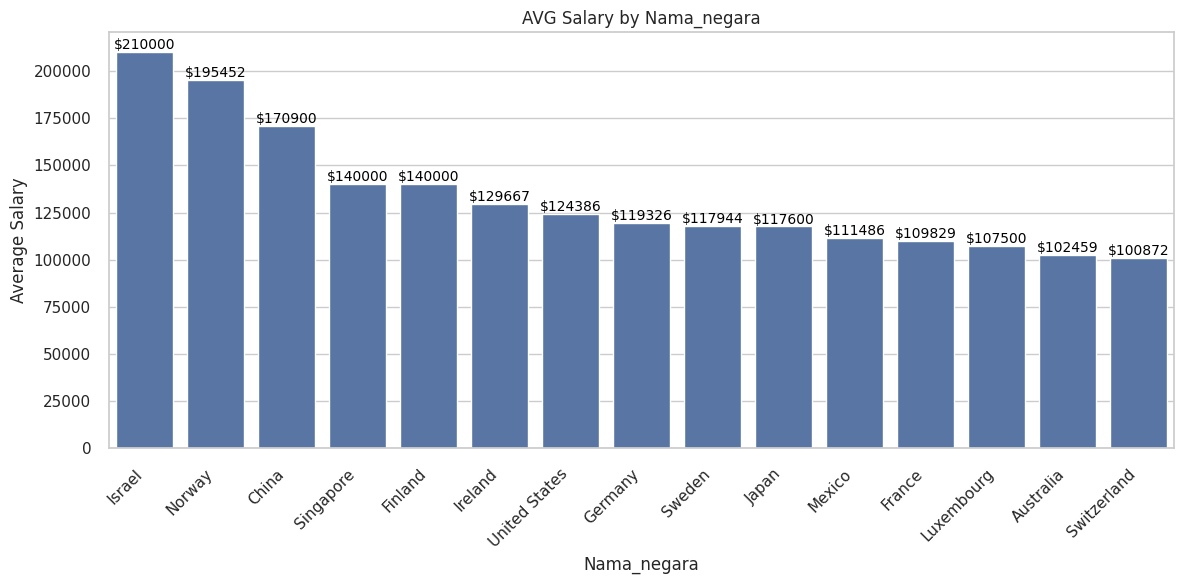

In [ ]:
plot_salary(df, 'nama_negara')

Ratio Gaji

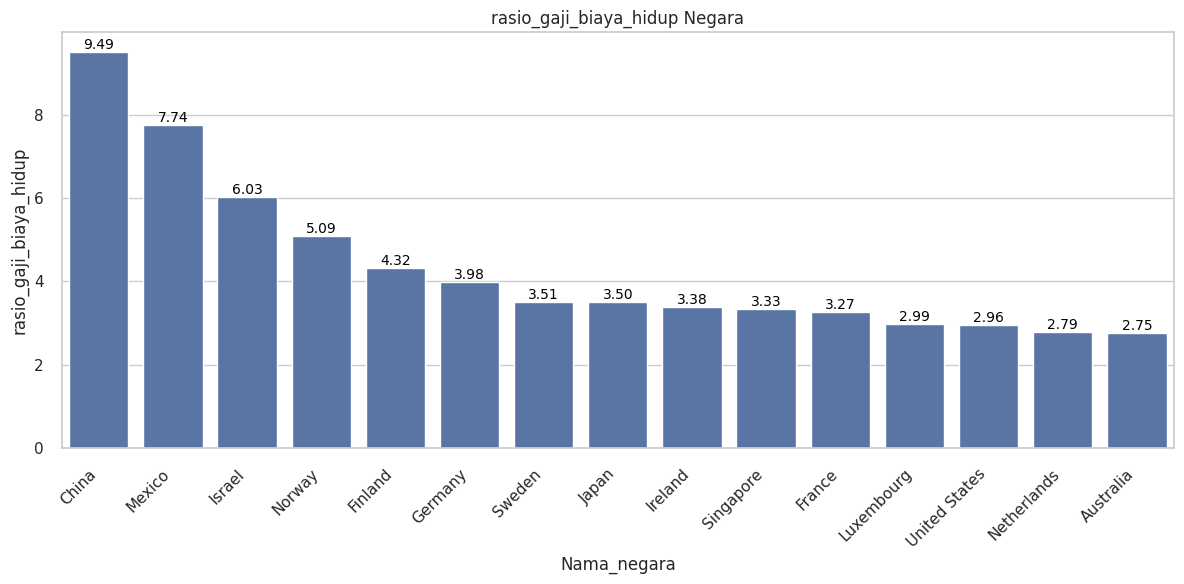

In [ ]:
mean_salary_by_column = df.groupby('nama_negara')['rasio_gaji_biaya_hidup'].mean().sort_values(ascending=False)
top_categories = mean_salary_by_column.head(15).index
filtered_df = df[df['nama_negara'].isin(top_categories)]
filtered_df['nama_negara'] = pd.Categorical(filtered_df['nama_negara'], categories=top_categories, ordered=True)
# Create the plot
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=filtered_df, x='nama_negara', y="rasio_gaji_biaya_hidup", estimator='mean', ci=None, order=top_categories)
plt.xticks(rotation=45, ha='right')
plt.title('rasio_gaji_biaya_hidup Negara')
plt.xlabel('nama_negara'.capitalize())
plt.ylabel('rasio_gaji_biaya_hidup')
plt.tight_layout()
for p in ax.patches:
  ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
     ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
     textcoords='offset points')
plt.show()

##Hubungan antara Jumlah Karyawan dan Jumlah Followers

<Figure size 1000x600 with 0 Axes>

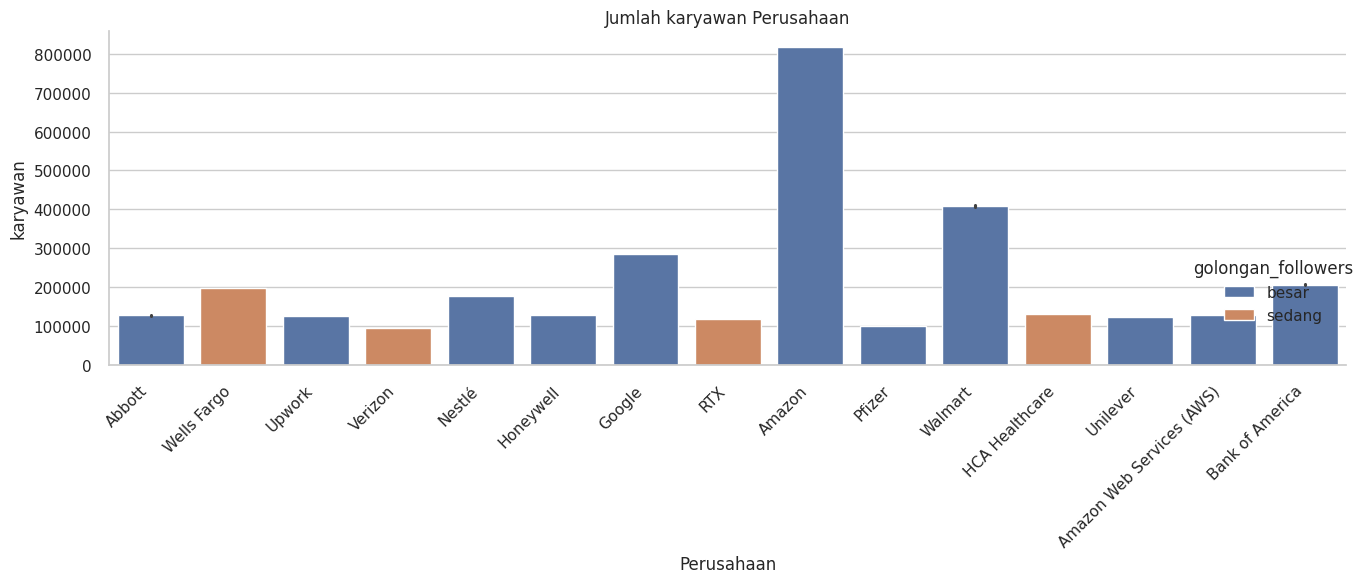

In [ ]:
top_industries = df.groupby('nama_perusahaan')['jumlah_karyawan'].mean().nlargest(15).index
filtered_df = df[df['nama_perusahaan'].isin(top_industries)]

# Set style for seaborn plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.catplot(data=filtered_df, x="nama_perusahaan", y="jumlah_karyawan", kind='bar', hue="golongan_followers", height=6, aspect=2)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.title('Jumlah karyawan Perusahaan')  # Set title
plt.xlabel('Perusahaan')  # Set x-axis label
plt.ylabel('karyawan')  # Set y-axis label
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

<Figure size 1000x600 with 0 Axes>

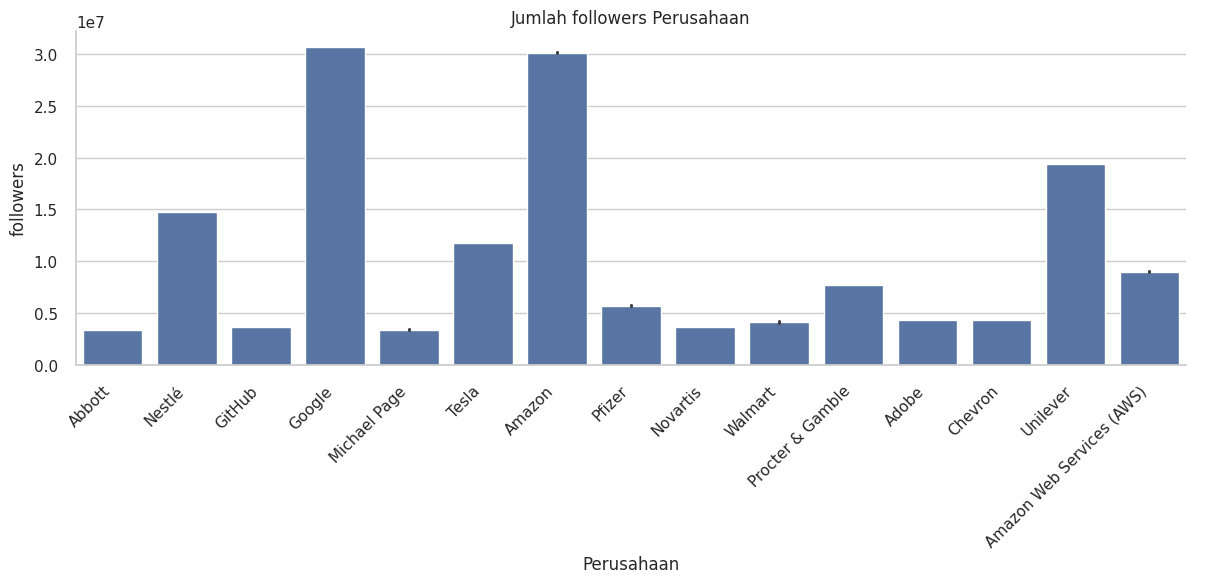

In [ ]:
top_industries = df.groupby('nama_perusahaan')['jumlah_follower'].mean().nlargest(15).index
filtered_df = df[df['nama_perusahaan'].isin(top_industries)]

# Set style for seaborn plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.catplot(data=filtered_df, x="nama_perusahaan", y="jumlah_follower", kind='bar', height=6, aspect=2)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.title('Jumlah followers Perusahaan')  # Set title
plt.xlabel('Perusahaan')  # Set x-axis label
plt.ylabel('followers')  # Set y-axis label
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

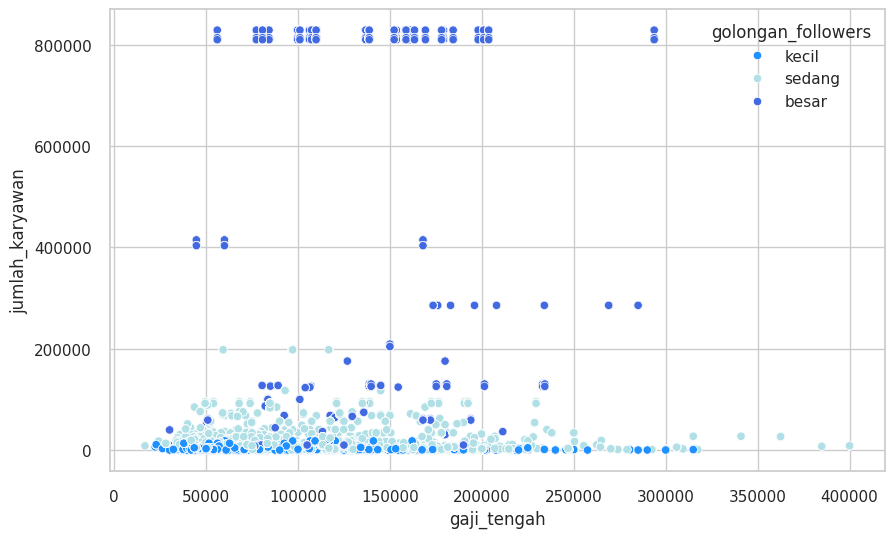

In [ ]:
custom_palette = {"sedang": "#B0E0E6", "kecil": "#1E90FF", "besar": "#4169E1"}

plt.figure(figsize=(10, 6))
sns.scatterplot(x='gaji_tengah', y='jumlah_karyawan', hue='golongan_followers', palette=custom_palette, data=df)
plt.show()


#Bagaimana pengelompokkan lowongan kerja agar pencari kerja mudah menemukan yang sesuai, dan perusahaan dapat menargetkan iklan secara efektif? **(Clustering)**

##Data Preprocessing

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.shape

(22062, 37)

In [ ]:
df_model = df[['tingkat_pengalaman_terformat', 'gaji_tengah', 'golongan_gaji',
                'jenis_pekerjaan_terformat', 'ukuran_perusahaan', 'diperbolehkan_jarak_jauh',
                'jenis_benefit', 'benefit', 'jumlah_karyawan', 'jumlah_follower', 'golongan_followers',
                'rasio_gaji_biaya_hidup', 'industry', 'tingkat_pengalaman_terformat', 'nama_kemampuan']]

In [ ]:
num = df_model.loc[:, df_model.dtypes != 'object']
cat = df_model.loc[:, df_model.dtypes == 'object']

In [ ]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22062 entries, 276 to 356114
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tingkat_pengalaman_terformat  22062 non-null  object 
 1   gaji_tengah                   22062 non-null  float64
 2   golongan_gaji                 22062 non-null  object 
 3   jenis_pekerjaan_terformat     22062 non-null  object 
 4   ukuran_perusahaan             22062 non-null  float64
 5   diperbolehkan_jarak_jauh      22062 non-null  float64
 6   jenis_benefit                 22062 non-null  object 
 7   benefit                       22062 non-null  float64
 8   jumlah_karyawan               22062 non-null  float64
 9   jumlah_follower               22062 non-null  float64
 10  golongan_followers            22062 non-null  object 
 11  rasio_gaji_biaya_hidup        22062 non-null  float64
 12  industry                      22062 non-null  object 
 13  tin

#Modelling

In [ ]:
#Get list of categorical variables
s = (df_model.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['tingkat_pengalaman_terformat', 'golongan_gaji', 'jenis_pekerjaan_terformat', 'jenis_benefit', 'golongan_followers', 'industry', 'tingkat_pengalaman_terformat', 'nama_kemampuan']


In [ ]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    df_model[i]=df_model[[i]].apply(LE.fit_transform)

In [ ]:
# Membuat objek StandardScaler
scaler = StandardScaler()

# Melakukan standarisasi pada fitur-fitur numerik
df_scaled = scaler.fit_transform(df_model)

In [ ]:
pca = PCA(n_components=3)
pca.fit(df_scaled)
PCA_ds = pd.DataFrame(pca.transform(df_scaled), columns=(["col1","col2",'col3']))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,22062.0,-8.244898e-17,1.950263,-3.013121,-1.351031,-0.724131,0.608127,5.113978
col2,22062.0,0.000000e+00,1.532545,-2.362708,-1.120918,-0.029446,0.524539,6.408414
col3,22062.0,6.183674e-17,1.262259,-4.411793,-0.802674,-0.051352,0.781929,5.049761


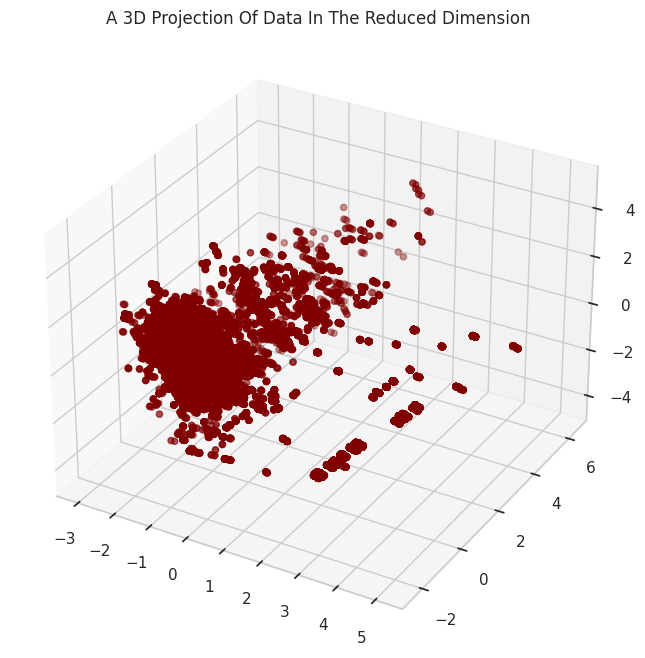

In [ ]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


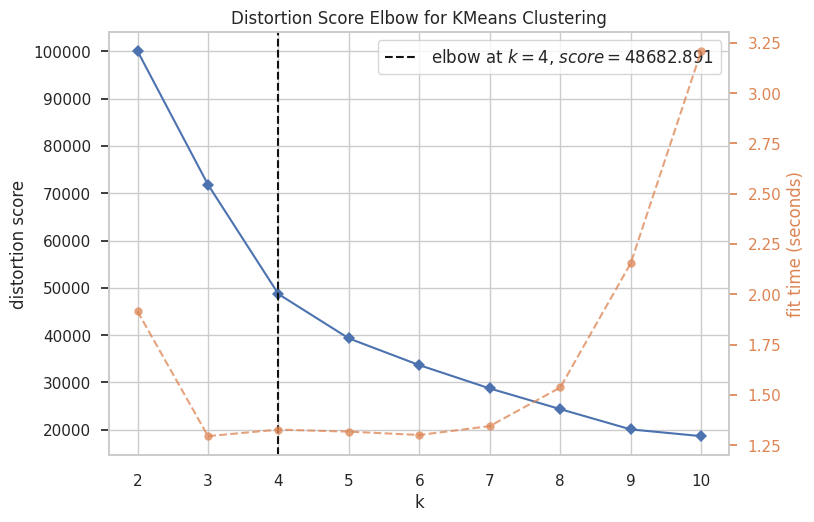

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [ ]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
df["Clusters"]= yhat_AC

In [ ]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
yhat_dbscan = dbscan.fit_predict(PCA_ds)
PCA_ds["Clusters_DBSCAN"] = yhat_dbscan
df["Clusters_DBSCAN"] = yhat_dbscan

In [ ]:
# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
yhat_kmeans = kmeans.fit_predict(PCA_ds)
PCA_ds["Clusters_KMeans"] = yhat_kmeans
df["Clusters_KMeans"] = yhat_kmeans

In [ ]:
# Evaluation Metrics for Agglomerative Clustering
silhouette_ac = silhouette_score(PCA_ds, yhat_AC)
print(f"Agglomerative Clustering Silhouette Score: {silhouette_ac}")

# Evaluation Metrics for DBSCAN
silhouette_dbscan = silhouette_score(PCA_ds, yhat_dbscan) if len(set(yhat_dbscan)) > 1 else -1

print(f"DBSCAN Silhouette Score: {silhouette_dbscan}")

# Evaluation Metrics for KMeans
silhouette_kmeans = silhouette_score(PCA_ds, yhat_kmeans)

print(f"KMeans Silhouette Score: {silhouette_kmeans}")

Agglomerative Clustering Silhouette Score: 0.4775108712399043
DBSCAN Silhouette Score: 0.6838716899328815
KMeans Silhouette Score: 0.6126523289932799


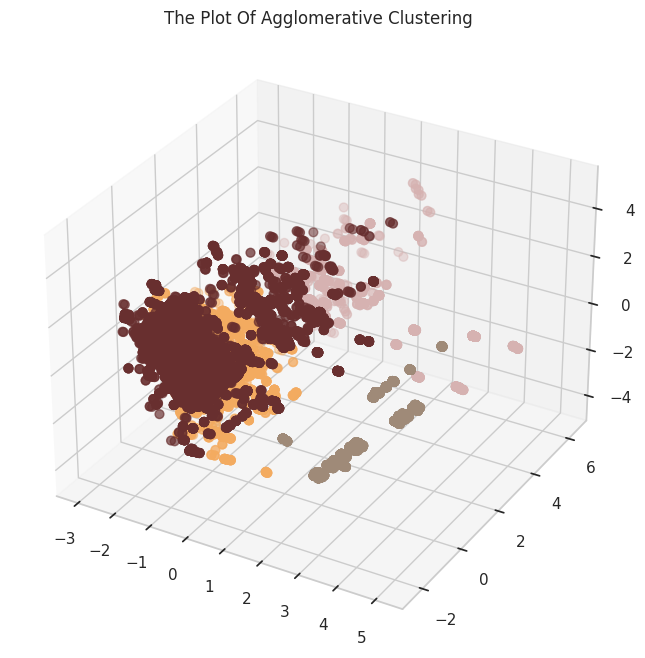

In [ ]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of Agglomerative Clustering")
plt.show()

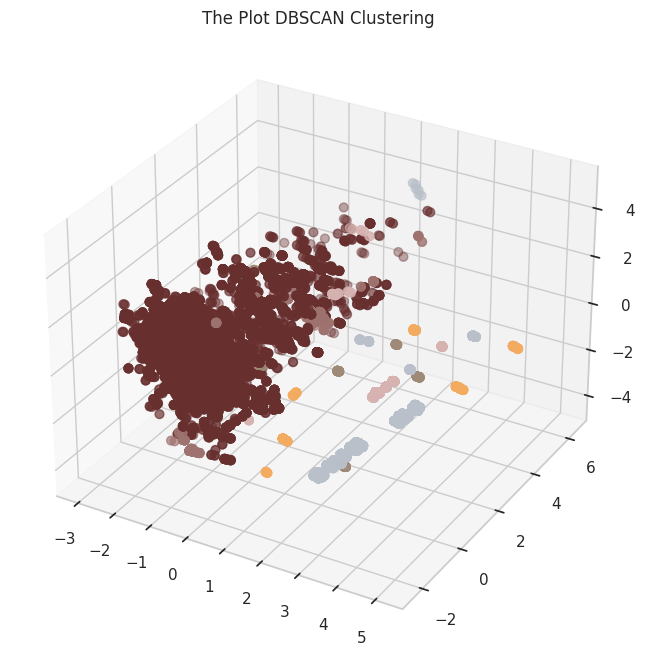

In [ ]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_DBSCAN"], marker='o', cmap = cmap )
ax.set_title("The Plot DBSCAN Clustering")
plt.show()

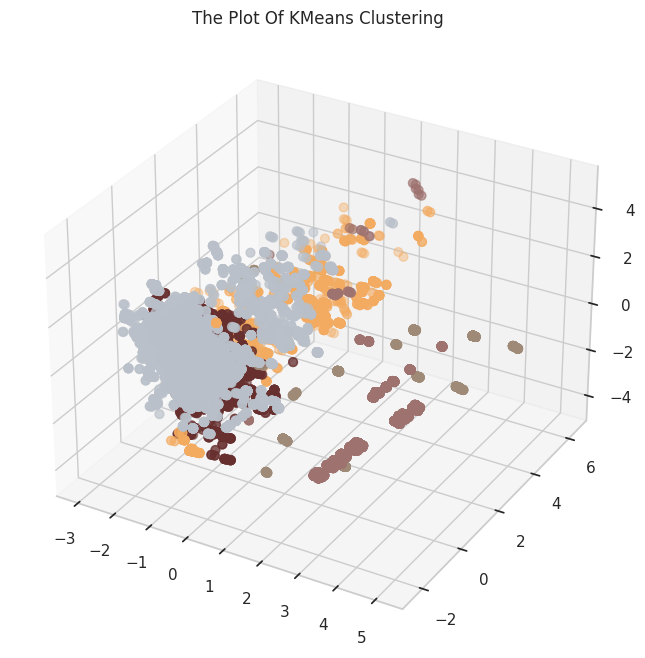

In [ ]:
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])

#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters_KMeans"], marker='o', cmap = cmap )
ax.set_title("The Plot Of KMeans Clustering")
plt.show()

#EDA Clustering

##Jumlah Lowongan Pekerjaan berdasarkan Clusters

Cluster 0 merupakan cluster dengan jumlah lowongan pekerjaan terbanyak, yaitu kurang dari 8000 loker. Cluster 1 memiliki kurang dari 7000 loker, cluster 2 lebih dari 3000 loker, cluster 3 lebih dari 2000 loker, dan cluster 4 kurang dari 2000 loker.

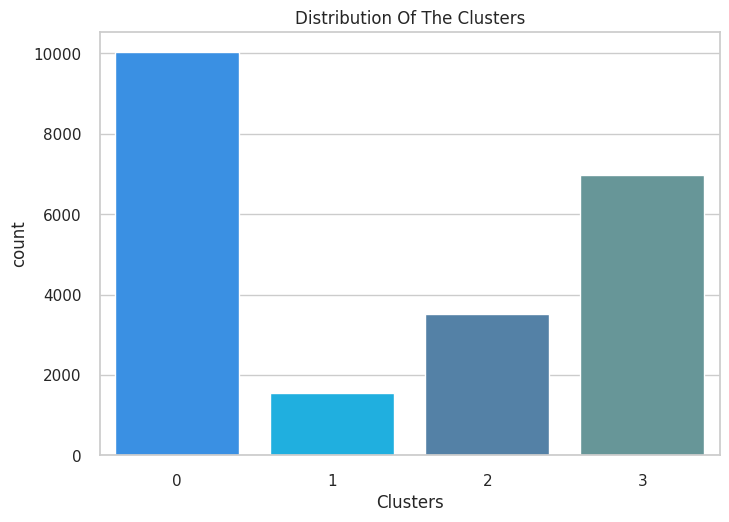

In [ ]:
#Plotting countplot of clusters
pal = ["#1E90FF","#00BFFF", "#4682B4","#5F9EA0", "#D6B2B1"]
pl = sns.countplot(x=df["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

###Hubungan antara Jumlah Karyawan dengan Gaji berdasarkan Cluster

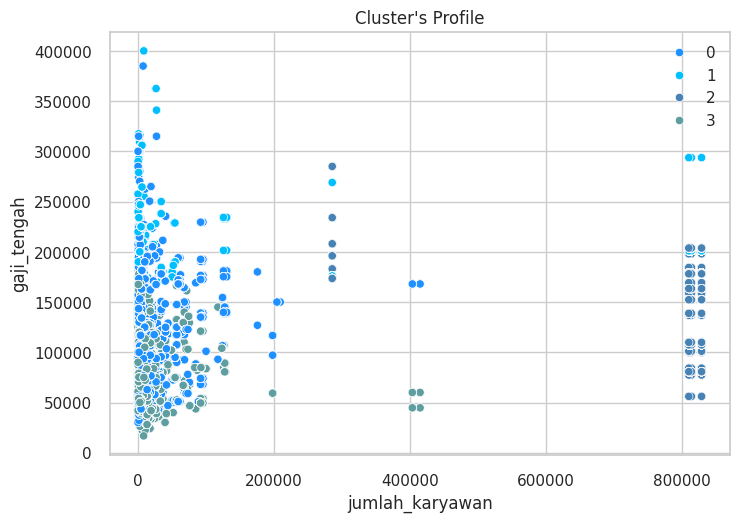

In [ ]:
pl = sns.scatterplot(data = df,x=df["jumlah_karyawan"], y=df["gaji_tengah"], hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile")
plt.legend()
plt.show()

In [ ]:
plt.figure()
pl=sns.boxenplot(x=df["Clusters"], y=df["jumlah_karyawan"], palette=pal)
plt.show()

###Hubungan antara Jumlah Followers dengan Gaji berdasarkan Cluster

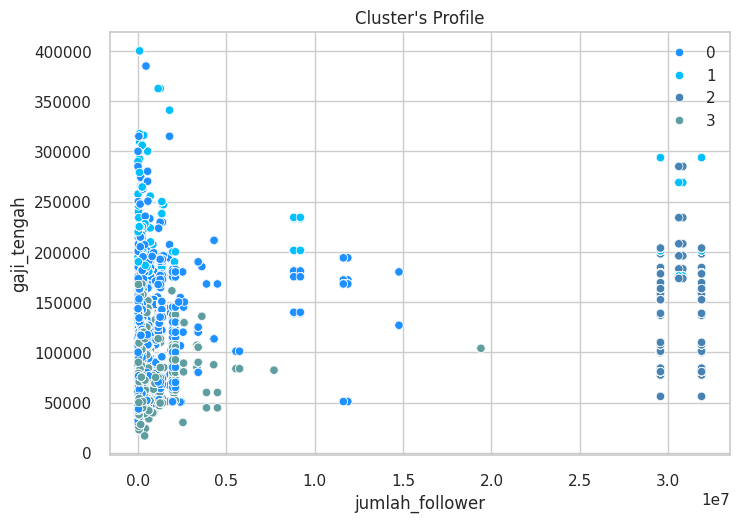

In [ ]:
pl = sns.scatterplot(data = df,x=df["jumlah_follower"], y=df["gaji_tengah"], hue=df["Clusters"], palette= pal)
pl.set_title("Cluster's Profile")
plt.legend()
plt.show()

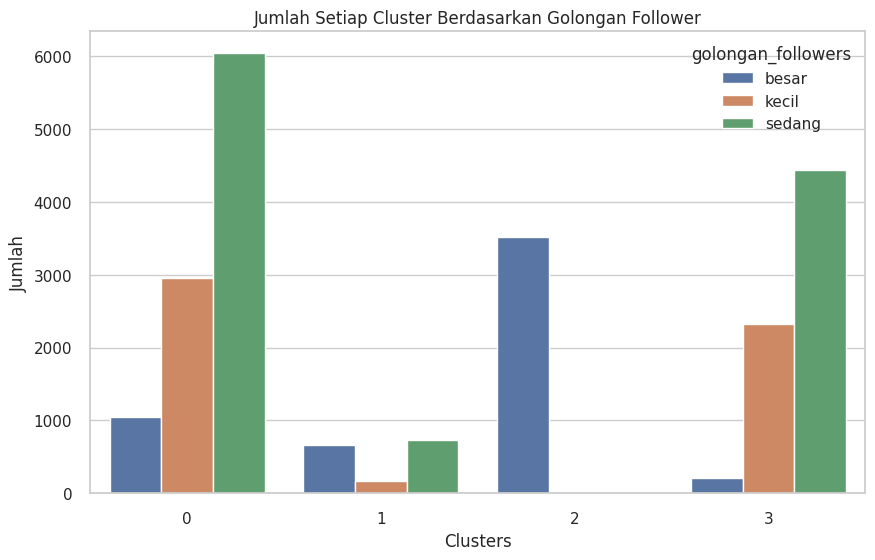

In [ ]:
# Menghitung jumlah setiap cluster berdasarkan 'benefit'
# df_counts = df[df['benefit']==1].groupby(['Clusters', 'benefit']).size().reset_index(name='count')
df_counts = df.groupby(['Clusters', 'golongan_followers']).size().reset_index(name='count')

# Membuat plot barchart
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df_counts, x='Clusters', y='count', hue='golongan_followers')

# Menambahkan judul dan label
plt.title('Jumlah Setiap Cluster Berdasarkan Golongan Follower')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')

# Menampilkan plot
plt.show()

##Melihat Hubungan Gaji dengan setiap Clusters

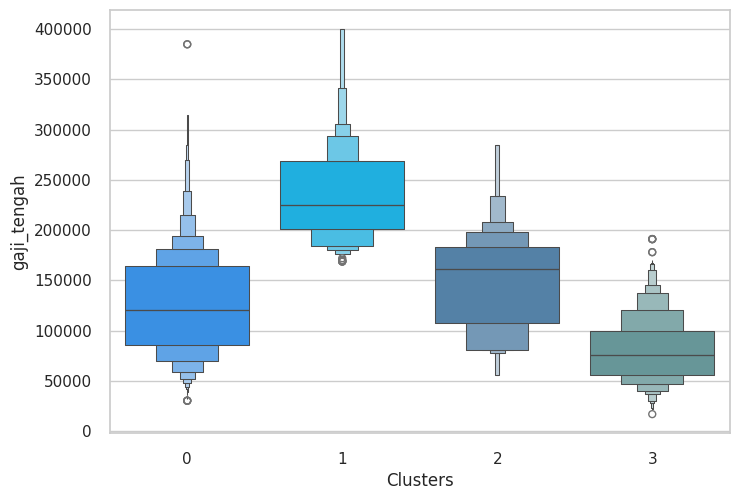

In [ ]:
plt.figure()
pl=sns.boxenplot(x=df["Clusters"], y=df["gaji_tengah"], palette=pal)
plt.show()

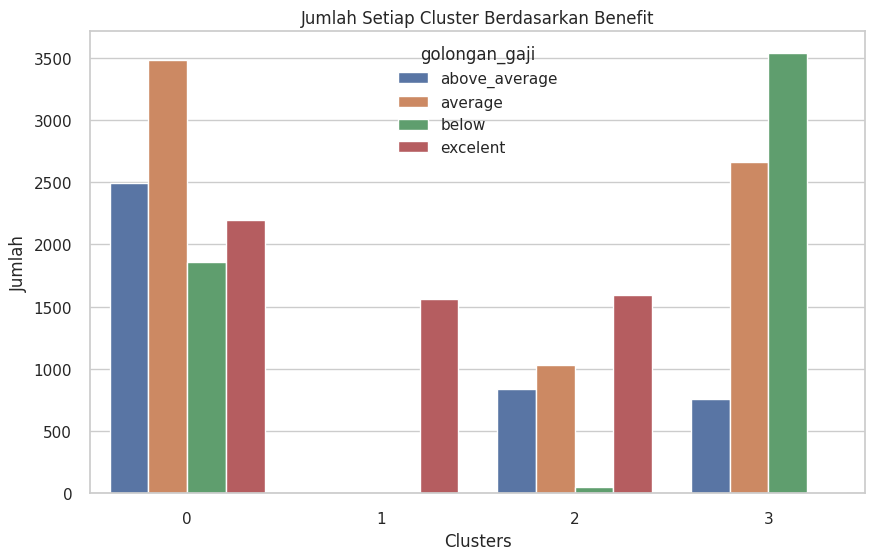

In [ ]:
# Menghitung jumlah setiap cluster berdasarkan 'benefit'
# df_counts = df[df['benefit']==1].groupby(['Clusters', 'benefit']).size().reset_index(name='count')
df_counts = df.groupby(['Clusters', 'golongan_gaji']).size().reset_index(name='count')

# Membuat plot barchart
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df_counts, x='Clusters', y='count', hue='golongan_gaji')

# Menambahkan judul dan label
plt.title('Jumlah Setiap Cluster Berdasarkan Benefit')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')

# Menampilkan plot
plt.show()

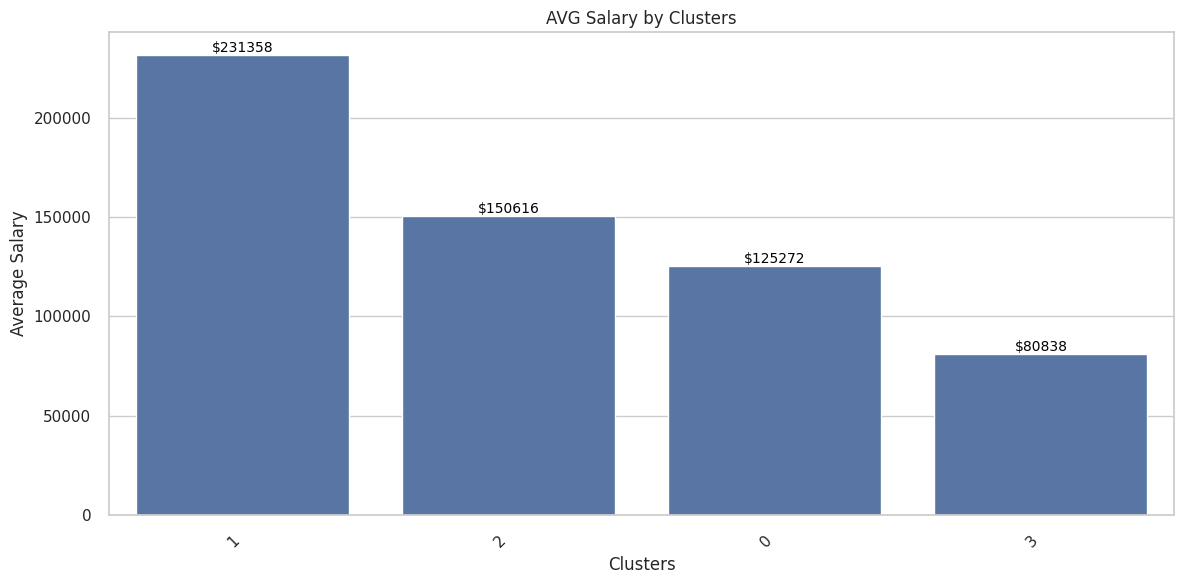

In [ ]:
plot_salary(df, 'Clusters')

##Hubungan Tingkat Pengalaman dengan Setiap Cluster

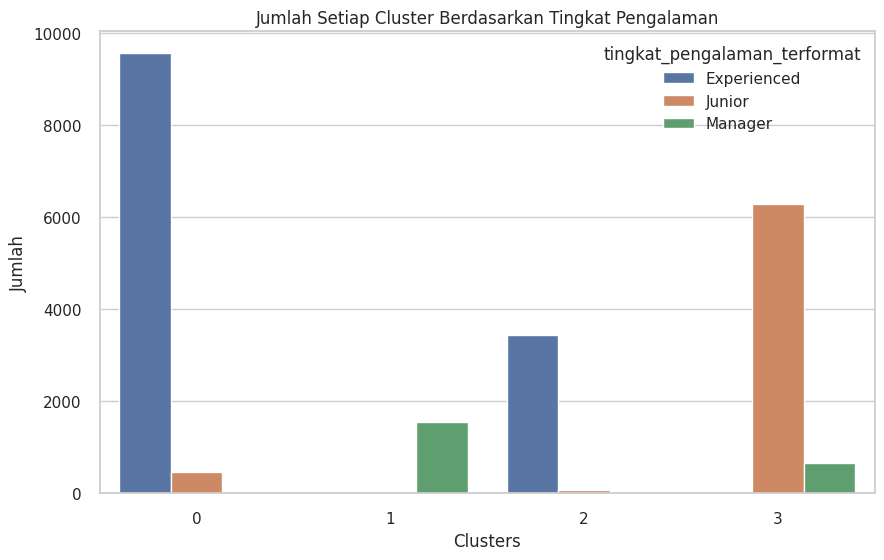

In [ ]:
# Menghitung jumlah setiap cluster berdasarkan 'tingkat_pengalaman_terformat'
df_counts = df.groupby(['Clusters', 'tingkat_pengalaman_terformat']).size().reset_index(name='count')
#df_counts = df[df['tingkat_pengalaman_terformat']!='Manager'].groupby(['Clusters', 'tingkat_pengalaman_terformat']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df_counts, x='Clusters', y='count', hue='tingkat_pengalaman_terformat')
plt.title('Jumlah Setiap Cluster Berdasarkan Tingkat Pengalaman')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.show()

##Hubungan Jenis Pekerjaan dengan Seriap Cluster

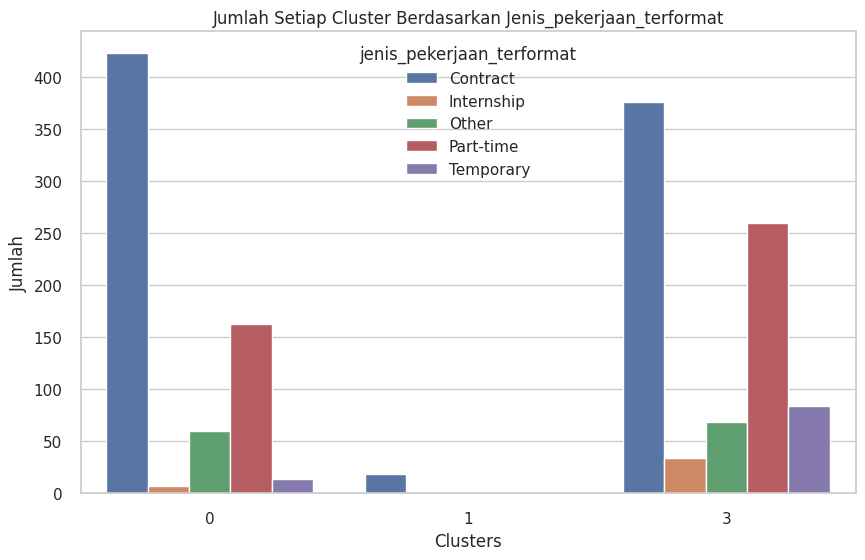

In [ ]:
# Menghitung jumlah setiap cluster berdasarkan 'jenis_pekerjaan_terformat'
df_counts = df[df['jenis_pekerjaan_terformat']!='Full-time'].groupby(['Clusters', 'jenis_pekerjaan_terformat']).size().reset_index(name='count')
#df_counts = df.groupby(['Clusters', 'jenis_pekerjaan_terformat']).size().reset_index(name='count')

# Membuat plot barchart
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df_counts, x='Clusters', y='count', hue='jenis_pekerjaan_terformat')
plt.title('Jumlah Setiap Cluster Berdasarkan Jenis_pekerjaan_terformat')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.show()

##Hubungan Benefit dengan Setiap Cluster

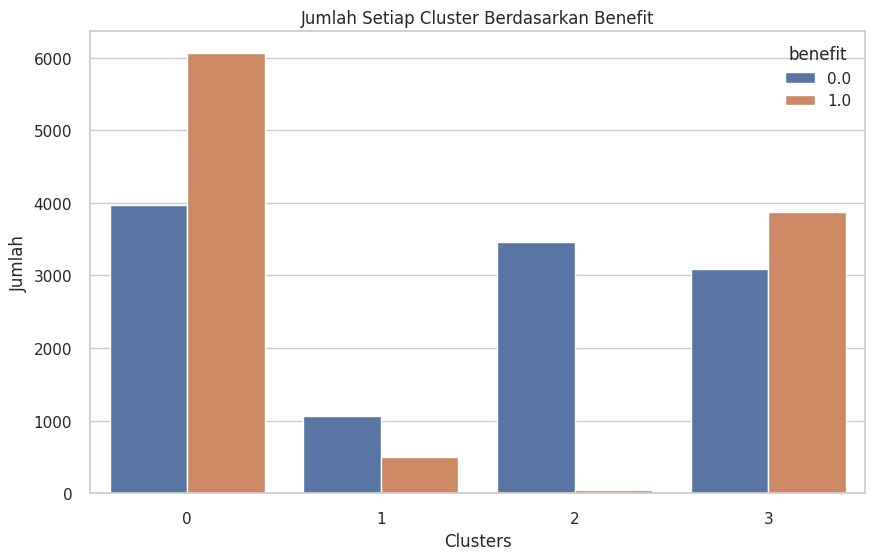

In [ ]:
# Menghitung jumlah setiap cluster berdasarkan 'benefit'
# df_counts = df[df['benefit']==1].groupby(['Clusters', 'benefit']).size().reset_index(name='count')
df_counts = df.groupby(['Clusters', 'benefit']).size().reset_index(name='count')

# Membuat plot barchart
plt.figure(figsize=(10, 6))
barchart = sns.barplot(data=df_counts, x='Clusters', y='count', hue='benefit')
plt.title('Jumlah Setiap Cluster Berdasarkan Benefit')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.show()

##Kemampuan yang paling dibutuhkan oleh setiap clusters

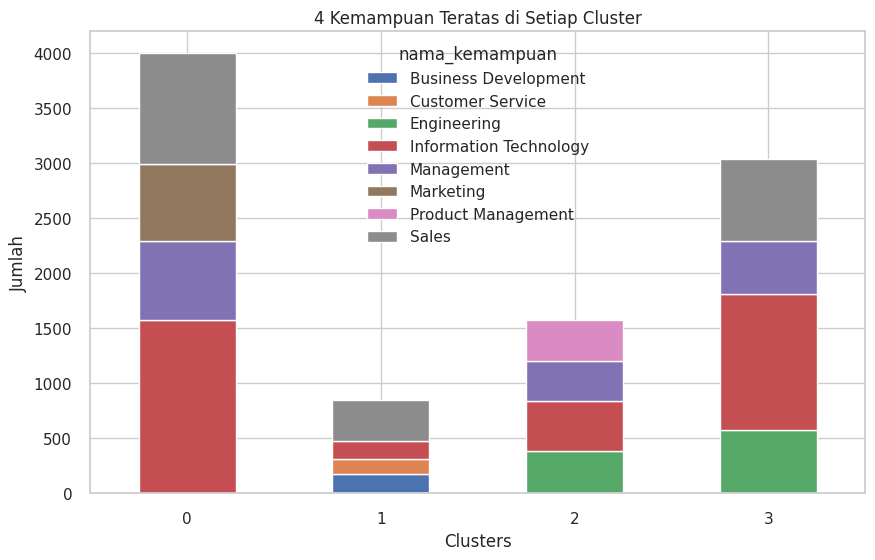

In [ ]:
# Filter baris yang tidak diinginkan
df_filtered = df[(df['nama_kemampuan'] != 'Other')]

# Mengelompokkan dan menghitung ukuran
count_kemampuan = df_filtered.groupby(['Clusters', 'nama_kemampuan']).size().reset_index(name='count')

# Memilih 3 kemampuan teratas di setiap klaster
top_kemampuan = count_kemampuan.groupby('Clusters').apply(
    lambda x: x.nlargest(4, 'count')
).reset_index(drop=True)

# Membuat tabel pivot
pivot_table = top_kemampuan.pivot(index='Clusters', columns='nama_kemampuan', values='count').fillna(0)

pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('4 Kemampuan Teratas di Setiap Cluster')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

##Industri yang paling dibutuhkan oleh setiap clusters

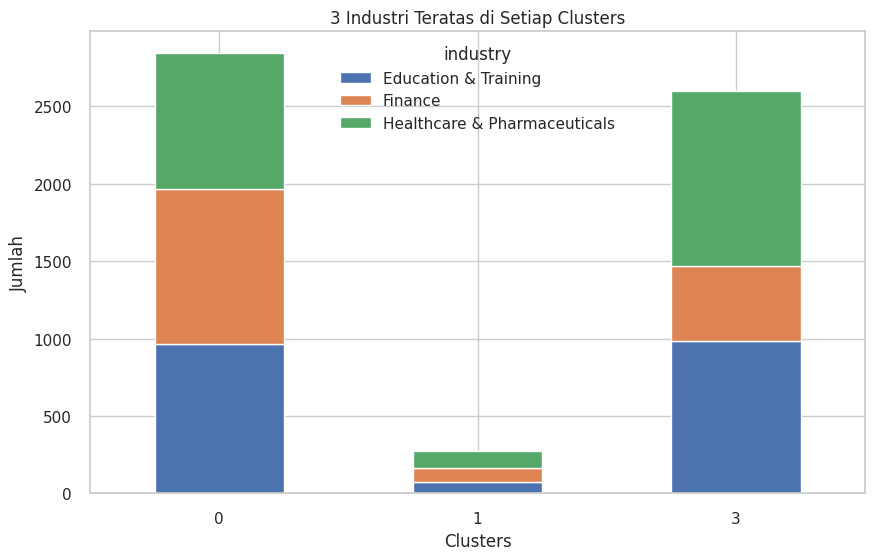

In [ ]:
# count_industri = df.groupby(['Clusters', 'industry']).size().reset_index(name='count')
count_industri = df[df['industry']!='Technology'].groupby(['Clusters', 'industry']).size().reset_index(name='count')
top_kemampuan = count_industri.groupby('Clusters').apply(
    lambda x: x.nlargest(3, 'count')
).reset_index(drop=True)

pivot_table = top_kemampuan.pivot(index='Clusters', columns='industry', values='count').fillna(0)
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('3 Industri Teratas di Setiap Clusters')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

##Negara dari Clusters (tidak informatif)

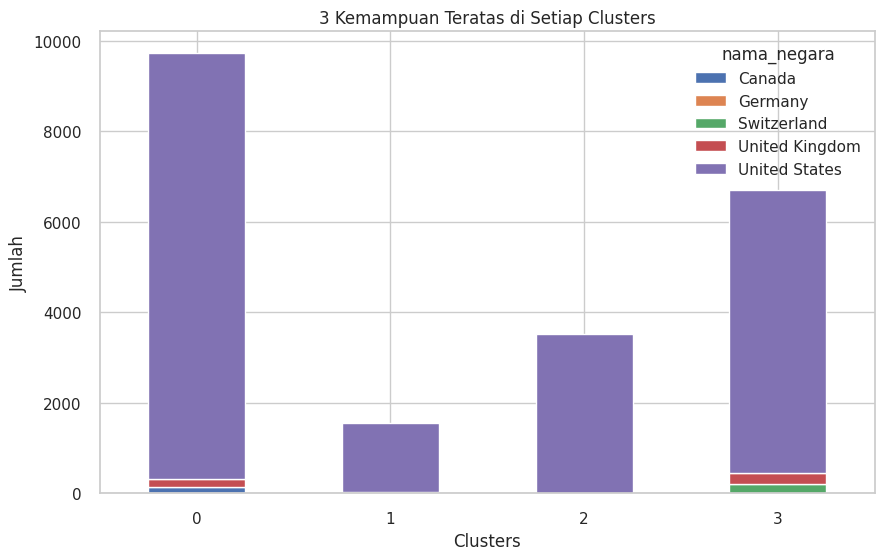

In [ ]:
count_industri = df.groupby(['Clusters', 'nama_negara']).size().reset_index(name='count')

top_kemampuan = count_industri.groupby('Clusters').apply(
    lambda x: x.nlargest(3, 'count')
).reset_index(drop=True)

pivot_table = top_kemampuan.pivot(index='Clusters', columns='nama_negara', values='count').fillna(0)
pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('3 Kemampuan Teratas di Setiap Clusters')
plt.xlabel('Clusters')
plt.ylabel('Jumlah')
plt.xticks(rotation=0)
plt.show()

##Rasio biaya hidup dengan clusters

<Figure size 1000x600 with 0 Axes>

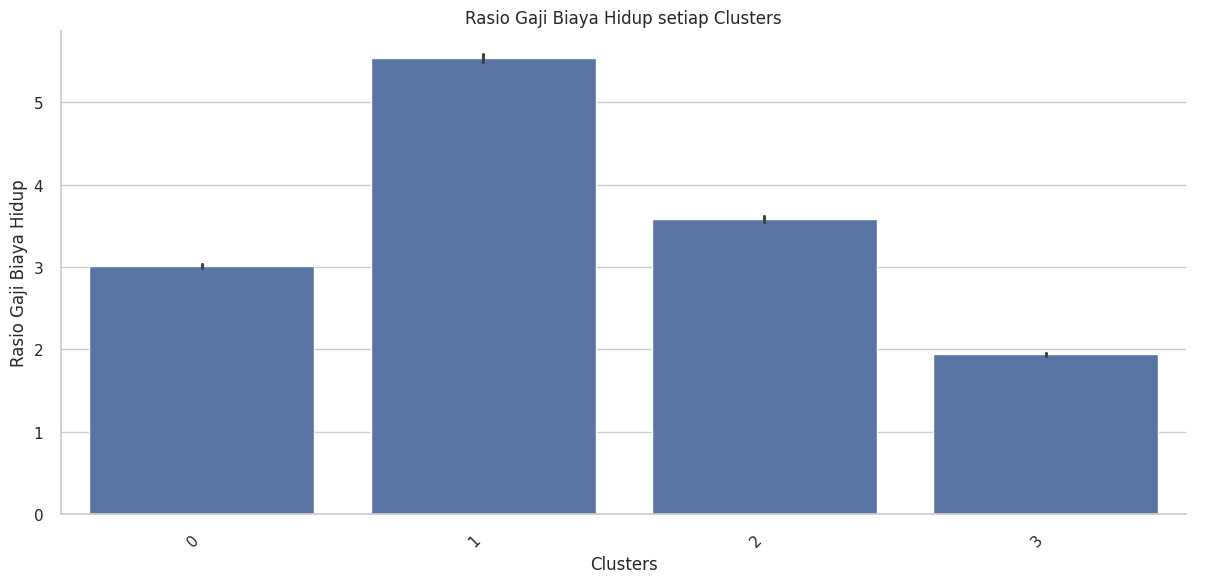

In [ ]:
top_industries = df.groupby('Clusters')['rasio_gaji_biaya_hidup'].mean().nlargest(15).index
filtered_df = df[df['Clusters'].isin(top_industries)]

# Set style for seaborn plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size
sns.catplot(data=filtered_df, x="Clusters", y="rasio_gaji_biaya_hidup", kind='bar', height=6, aspect=2)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels
plt.title('Rasio Gaji Biaya Hidup setiap Clusters')  # Set title
plt.xlabel('Clusters')  # Set x-axis label
plt.ylabel('Rasio Gaji Biaya Hidup')  # Set y-axis label
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

## Kesimpulan Profiling

1. Klaster 0:
-> Memiliki jumlah lowongan pekerjaan terbanyak <br>
-> Karyawannya sedikit dan perusahaan kecil. <br>
-> Jumlah followers Linkedin sedang atau kecil.<br>
-> Gaji rata-rata berkisar antara 50,000 hingga 250,000 USD. <br>
-> Sebagian kecil pekerjaan bersifat kontrak dan part-time.<br>
-> Sebagian besar lowongan pekerjaan membutuhkan tingkat pengalaman experienced<br>
-> Sebagian besar lowongan pekerjaan mendapatkan benefit<br>
-> Membutuhkan keterampilan dalam IT, sales, manajemen, dan pemasaran.<br>
-> Memiliki rasio gaji terhadap biaya hidup menengah.<br>
-> Sebagian Beroperasi di industri Pendidikan & Pelatihan. <br>


2. Klaster 1:
-> memiliki jumlah lowongan pekerjaan paling sedikit<br>
-> Karyawannya banyak.<br>
-> Jumlah followers  Linkedin besar.<br>
-> Gaji sangat baik berkisar antara 200,000 hingga 400,000 USD.<br>
-> Sebagian besar Pekerjaan berjenis Full-time.<br>
-> Semua lowongan pekerjaan membutuhkan tingkat pengalaman manager<br>
-> Sebagian besar lowongan pekerjaan tidak mendapatkan benefit<br>
-> Membutuhkan keterampilan dalam sales, pengembangan bisnis, bisnis umum, dan layanan pelanggan.<br>
-> Memiliki rasio gaji terhadap biaya hidup tertinggi<br>
-> Sebagian Beroperasi di industri Keuangan.<br>


3. Klaster 2:
-> Karyawannya banyak.<br>
-> Jumlah followers Linkedin besar.<br>
-> Gaji sangat baik berkisar antara 75,000 hingga 300,000.<br>
-> Semua lowongan pekerjaan bersifat full-time.<br>
-> Sebagian besar lowongan pekerjaan membutuhkan tingkat pengalaman experienced<br>
-> Hampir semua lowongan pekerjaan tidak mendapatkan benefit<br>
-> Membutuhkan keterampilan dalam manajemen produk, IT, manajemen, dan manajemen proyek.<br>
-> Memiliki rasio gaji terhadap biaya hidup tinggi.<br>
-> Semua lowongan pekerjaan merupakan industry teknologi<br>

4. Klaster 3:
-> Karyawannya sedikit.<br>
-> Jumlah followers Linkedin sedang atau kecil.<br>
-> Gaji di bawah rata-rata berkisar antara 25,000 hingga 150,000.<br>
-> Sebagian kecil pekerjaan bersifat kontrak, part-time, temporary, atau internship.<br>
-> Sebagian besar lowongan pekerjaan membutuhkan tingkat pengalaman junior.<br>
-> Sebagian besar lowongan pekerjaan  mendapatkan benefit<br>
-> Membutuhkan keterampilan dalam IT, sales, teknik, dan manufaktur.<br>
-> Memiliki rasio gaji terhadap biaya hidup terendah<br>
-> Sebagian beroperasi di industri Kesehatan & Farmasi.<br>

### Ringkasan:
* Cluster 0: Startup atau SMEs dengan tingkat pengalaman experienced.
* Cluster 1: Corporate besar atau multinational companies dengan tingkat pengalaman manager.
* Cluster 2: Corporate besar atau perusahaan teknologi dengan tingkat pengalaman experienced.
* Cluster 3: Startup atau SMEs dengan tingkat pengalaman junior.


#Model NLP

In [ ]:
df.head(3)

,id_perusahaan,id_pekerjaan,nama_perusahaan,nama_industri,judul,jenis_pekerjaan_terformat,tingkat_pengalaman_terformat,gaji_minimal,gaji_tengah,gaji_maksimal,golongan_gaji,periode_pembayaran,rasio_gaji_biaya_hidup,mata_uang,diperbolehkan_jarak_jauh,tipe_pendaftaran,tipe_kompensasi,benefit,jenis_benefit,ukuran_perusahaan,jumlah_karyawan,jumlah_follower,golongan_followers,disponsori,deskripsi_keterampilan,singkatan_kemampuan,nama_kemampuan,deskripsi_x,deskripsi_y,nama_negara,negara_bagian,kota,lokasi,jumlah_tampilan,industry,big_industry,course,Clusters,Clusters_DBSCAN,Clusters_KMeans
276,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,401(k),6.0,244.0,3203.0,kecil,0,NA,MGMT,Management,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...,0,0,2
277,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,401(k),6.0,244.0,3203.0,kecil,0,NA,MNFC,Manufacturing,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...,0,0,2
278,10515052,3757932846,Boyd Group Services Inc.,Automotive,Estimator In Training,Full-time,Experienced,29120.0,35360.0,41600.0,below,YEARLY,0.982222,USD,0.0,OffsiteApply,BASE_SALARY,1.0,Vision insurance,6.0,244.0,3203.0,kecil,0,NA,MGMT,Management,Company: Gerber Collision & Glass\n\nWELCOME T...,Boyd Group Services Inc. (”BGSI”) is a Canadia...,Canada,Manitoba,Winnipeg,"Marietta, GA",2.0,Automotive,Automotive,Electric Cars: Introduction to Electric Powert...,0,0,2


In [ ]:
df.dropna(inplace=True)

Menggunakan Sinonim untuk menambah data training untuk model

In [ ]:
# Fungsi untuk mendapatkan sinonim dari sebuah kata menggunakan WordNet
def get_synonyms(text):
    synonyms = set()
    tokens = word_tokenize(text)
    for token in tokens:
        for syn in wordnet.synsets(token):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
    return list(synonyms)

df['industry_synonyms'] = df['big_industry'].apply(lambda x: get_synonyms(x))
df['skill_synonyms'] = df['nama_kemampuan'].apply(lambda x: get_synonyms(x))
df['pengalaman_synonyms'] = df['tingkat_pengalaman_terformat'].apply(lambda x: get_synonyms(x))

In [ ]:
# Assuming df_nlp['deskripsi_bersih_augmented'] is a column containing lists
df['industry_synonyms'] = df['industry_synonyms'].apply(lambda x: ' '.join(x))
df['skill_synonyms'] = df['skill_synonyms'].apply(lambda x: ' '.join(x))
df['pengalaman_synonyms'] = df['pengalaman_synonyms'].apply(lambda x: ' '.join(x))

In [ ]:
df.shape

(22062, 43)

###Pembuatan Fitur baru menggunakan bantuan TRANSFORMER text-generation untuk membuat fitur baru bernama ‘deskripsi_skill’.

In [ ]:
# from transformers import pipeline
# from tqdm import tqdm  # Import tqdm
# !pip install transformers pandas

# # Define the NLP pipeline for text generation
# nlp = pipeline("text-generation", model="gpt2")

# # Function to create skill descriptions using the NLP model
# def create_skill_description(row):
#     experience_placeholder = "I have been working in this industry for"  # Placeholder for experience
#     prompt = (f"I am a job seeker in {row['nama_industri']} industry with a skill in {row['nama_kemampuan']} "
#               f"and {row['tingkat_pengalaman_terformat']} experience. {experience_placeholder}")
#     generated = nlp(prompt, max_length=50, num_return_sequences=1)
#     return generated[0]['generated_text']

# # Apply the function to each row to create the 'deskripsi_skill' column
# tqdm.pandas()  # Use tqdm with pandas
# df['deskripsi_skill'] = df.progress_apply(create_skill_description, axis=1)

# df.to_csv('new.csv', sep='\t', encoding='utf-8')

In [ ]:
new.shape

(22066, 7)

In [ ]:
new_selected = new[['id_pekerjaan', 'deskripsi_skill']]
df = pd.merge(df, new_selected, on='id_pekerjaan', how='left')

In [ ]:
df.shape

(802012, 44)

In [ ]:
# Drop Duplicates and missing value
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

df.shape

(437848, 44)

###Feature Selection untuk tahap Modelling

In [ ]:
df_nlp = df[['id_pekerjaan','industry', 'nama_kemampuan', 'tingkat_pengalaman_terformat', 'industry_synonyms',
             'skill_synonyms','pengalaman_synonyms','deskripsi_skill','gaji_tengah', 'Clusters', 'course']]

In [ ]:
df_nlp.drop_duplicates(inplace=True)
df_nlp.dropna(inplace=True)

# # Menghapus duplikat berdasarkan kolom 'id_pekerjaan'
# df_nlp.drop_duplicates(subset=['id_pekerjaan'], inplace=True)

In [ ]:
df_nlp.shape

(60762, 11)

In [ ]:
df_nlp['deskripsi'] = df_nlp.drop(columns=['gaji_tengah', 'deskripsi_skill', 'id_pekerjaan', 'Clusters','course'
                                          ]).apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)
    return text

# Terapkan pembersihan teks pada kolom 'deskripsi'
df_nlp['deskripsi_bersih'] = df_nlp['deskripsi'].apply(clean_text)
df_nlp['deskripsi_skill_bersih'] = df_nlp['deskripsi_skill'].apply(clean_text)

In [ ]:
# def remove_duplicates(text):
#     # Pisahkan teks menjadi kata-kata
#     words = text.split()
#     seen = {}
#     result = []
#     for word in words:
#         if word not in seen:
#             seen[word] = 1
#             result.append(word)
#     return ' '.join(result)

# # Terapkan fungsi ke kolom deskripsi_bersih
# df_nlp['deskripsi_bersih'] = df_nlp['deskripsi_bersih'].apply(remove_duplicates)

In [ ]:
# Gabungkan kedua kolom deskripsi
df_nlp['deskripsi_gabungan'] = df_nlp['deskripsi_skill_bersih'] + ' ' + df_nlp['deskripsi_bersih']

# Preprocessing text
df_nlp['deskripsi_gabungan'] = df_nlp['deskripsi_gabungan'].apply(clean_text)
df_nlp['deskripsi_bersih'] = df_nlp['deskripsi_bersih'].apply(clean_text)
df_nlp['deskripsi_skill_bersih'] = df_nlp['deskripsi_skill_bersih'].apply(clean_text)

In [ ]:
# Splitting data
# X = df_nlp['deskripsi_skill_bersih']
X = df_nlp['deskripsi_gabungan']
y = df_nlp['Clusters']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Memisahkan data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
X[0]

In [ ]:
df_nlp['deskripsi_bersih'][0]

In [ ]:
temp = df_nlp.copy()
temp['word_count'] = temp['deskripsi_gabungan'].apply(lambda x: len(str(x).split()))
min_words = temp['word_count'].min()
max_words = temp['word_count'].max()
mean_words = temp['word_count'].mean()

print(f"Jumlah kata minimal dalam kolom 'deskripsi': {min_words}")
print(f"Jumlah kata maksimal dalam kolom 'deskripsi': {max_words}")
print(f"Jumlah kata avg dalam kolom 'deskripsi': {mean_words}")

In [ ]:
# Inisialisasi tokenizer tanpa batasan jumlah kata
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

# Dapatkan frekuensi kata
word_counts = tokenizer.word_counts

# Urutkan berdasarkan frekuensi
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Hitung jumlah total kata unik
total_unique_words = len(word_counts)
print(f"Total unique words: {total_unique_words}")

In [ ]:
# Buat list frekuensi kata
frequencies = np.array([count for _, count in sorted_word_counts])

# Hitung kumulatif frekuensi
cumulative_frequencies = np.cumsum(frequencies)

# Tentukan total kata yang mencakup 95% dari teks
total_words = np.sum(frequencies)
target_coverage = 0.95
num_words_95_coverage = np.searchsorted(cumulative_frequencies, target_coverage * total_words)

print(f"Jumlah kata yang mencakup 95% dari teks: {num_words_95_coverage}")

In [ ]:
def preprocess_texts(texts):
    preprocessed_texts = []
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    for text in texts:
        # Lowercase the text
        text = text.lower()

        # Remove non-alphanumeric characters and multiple spaces
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text)

        # Tokenize the text
        tokens = word_tokenize(text)

        # Remove stop words and perform lemmatization
        filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

        # Join tokens back into a single string
        preprocessed_text = ' '.join(filtered_tokens)
        preprocessed_texts.append(preprocessed_text)

    return preprocessed_texts

In [ ]:
new_texts = [
    "I am a job seeker in the Information Technology industry with a skill in Software Development and with Junior Level experience. I have been working in this industry for the last 1 year.",
    "I am aiming for a position in the Marketing industry with expertise in Digital Marketing and Senior Level experience. I have been working in this industry for the past 5 years.",
    "I am searching for a role in the Finance industry with skill in Risk Management and Managerial level experience. I have been working as a manager in this industry for over 15 years."
]

#Modelling LSTM

In [ ]:
# Tokenisasi dan vektorisasi teks
tokenizer = Tokenizer(num_words=700)  # Ubah n menjadi jumlah kata yang sesuai
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_padded = pad_sequences(X_train_seq, maxlen=93)  # Sesuaikan maxlen dengan panjang maksimum teks Anda
X_test_padded = pad_sequences(X_test_seq, maxlen=93)  # Sesuaikan dengan panjang maksimum teks Anda

# Membangun model LSTM
model = Sequential()
model.add(Embedding(input_dim=700, output_dim=100, input_length=93))
model.add(LSTM(128, activation='tanh'))  # Menggunakan aktivasi tanh
model.add(Dropout(0.5))  # Dropout tambahan untuk regularisasi
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))  # Ganti len(np.unique(y_encoded)) sesuai jumlah kelas

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model
history = model.fit(X_train_padded, y_train, batch_size=32, epochs=5, validation_data=(X_test_padded, y_test))

# Evaluasi model pada data training dan testing
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)

print(f'Training Loss: {train_loss}, Training Accuracy: {train_accuracy}')
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

Epoch 1/5
1520/1520 [==============================] - 42s 25ms/step - loss: 0.2888 - accuracy: 0.8840 - val_loss: 0.2145 - val_accuracy: 0.9078
Epoch 2/5
1520/1520 [==============================] - 14s 9ms/step - loss: 0.2050 - accuracy: 0.9158 - val_loss: 0.1860 - val_accuracy: 0.9226
Epoch 3/5
1520/1520 [==============================] - 13s 8ms/step - loss: 0.1851 - accuracy: 0.9247 - val_loss: 0.1851 - val_accuracy: 0.9235
Epoch 4/5
1520/1520 [==============================] - 13s 9ms/step - loss: 0.1706 - accuracy: 0.9317 - val_loss: 0.1630 - val_accuracy: 0.9329
Epoch 5/5
380/380 [==============================] - 1s 4ms/step - loss: 0.1502 - accuracy: 0.9375
Training Loss: 0.1386423259973526, Training Accuracy: 0.9431175589561462
Test Loss: 0.15017692744731903, Test Accuracy: 0.9374639987945557


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Predict probabilities for training and testing data
train_pred_prob = model.predict(X_train_padded)
test_pred_prob = model.predict(X_test_padded)

# Convert probabilities to predicted classes
train_pred = np.argmax(train_pred_prob, axis=1)
test_pred = np.argmax(test_pred_prob, axis=1)

# Calculate precision, recall, and F1 score for training and testing data
train_precision = precision_score(y_train, train_pred, average='weighted')
train_recall = recall_score(y_train, train_pred, average='weighted')
train_f1 = f1_score(y_train, train_pred, average='weighted')

test_precision = precision_score(y_test, test_pred, average='weighted')
test_recall = recall_score(y_test, test_pred, average='weighted')
test_f1 = f1_score(y_test, test_pred, average='weighted')

print(f'Training Precision: {train_precision:.2f}, Training Recall: {train_recall:.2f}, Training F1 Score: {train_f1:.2f}')
print(f'Test Precision: {test_precision:.2f}, Test Recall: {test_recall:.2f}, Test F1 Score: {test_f1:.2f}')

# Generate confusion matrix for training and testing data
train_conf_matrix = confusion_matrix(y_train, train_pred)
test_conf_matrix = confusion_matrix(y_test, test_pred)

print("\nTraining Confusion Matrix:\n", train_conf_matrix)
print("\nTesting Confusion Matrix:\n", test_conf_matrix)

380/380 [==============================] - 1s 3ms/step
Training Precision: 0.94, Training Recall: 0.94, Training F1 Score: 0.94
Test Precision: 0.94, Test Recall: 0.94, Test F1 Score: 0.94

Training Confusion Matrix:
 [[20561     0   924   391]
 [    0  3034     0   219]
 [ 1025     0  6957     0]
 [   56   147     3 15292]]

Testing Confusion Matrix:
 [[5176    0  255   84]
 [   0  802    0   54]
 [ 303    0 1711    0]
 [  20   43    1 3704]]


In [ ]:
preprocessed_new_texts = preprocess_texts(new_texts)

# Tokenisasi dan vektorisasi teks praproses
new_texts_seq = tokenizer.texts_to_sequences(preprocessed_new_texts)
new_texts_padded = pad_sequences(new_texts_seq, maxlen=93)

# Lakukan prediksi menggunakan model
predicted_labels = model.predict(new_texts_padded)

# Ubah prediksi kembali ke label asli sebelum dilakukan label encoding
predicted_categories = label_encoder.inverse_transform(np.argmax(predicted_labels, axis=1))

# Tampilkan hasil prediksi
for text, category in zip(new_texts, predicted_categories):
    print(f'Teks: {text}\nPrediksi Clusters: {category}\n')

1/1 [==============================] - 0s 50ms/step
Teks: I am a job seeker in the Information Technology industry with a skill in Software Development and with Junior Level experience. I have been working in this industry for the last 1 year.
Prediksi Clusters: 1

Teks: I am aiming for a position in the Marketing industry with expertise in Digital Marketing and Senior Level experience. I have been working in this industry for the past 5 years.
Prediksi Clusters: 3

Teks: I am searching for a role in the Finance industry with skill in Risk Management and Managerial level experience. I have been working as a manager in this industry for over 15 years.
Prediksi Clusters: 1



#BOW

Google Colab tidak memiliki cukup RAM saat melakukan Proses Ini, oleh karena itu kami Melakukan proses Metric Evaluation BOW pada Jupyter Notebook.

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# # Calculate accuracy
# accuracy = accuracy_score(df_nlp['Clusters'], df_nlp['Predicted_Clusters'])
# print(f"Accuracy: {accuracy:.2f}")

# # Calculate precision, recall, and F1 score
# precision = precision_score(df_nlp['Clusters'], df_nlp['Predicted_Clusters'], average='weighted')
# recall = recall_score(df_nlp['Clusters'], df_nlp['Predicted_Clusters'], average='weighted')
# f1 = f1_score(df_nlp['Clusters'], df_nlp['Predicted_Clusters'], average='weighted')

# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1:.2f}")

# # Generate classification report
# report = classification_report(df_nlp['Clusters'], df_nlp['Predicted_Clusters'])
# print("\nClassification Report:\n", report)

# # Generate confusion matrix
# conf_matrix = confusion_matrix(df_nlp['Clusters'], df_nlp['Predicted_Clusters'])
# print("\nConfusion Matrix:\n", conf_matrix)

Metric Evaluation BOW:

Accuracy: 0.88

Precision: 0.85

Recall: 0.88

F1 Score: 0.86

In [ ]:
# Preprocess new_texts
new_texts_clean = [clean_text(text) for text in new_texts]

# Bag of Words
cv = CountVectorizer()
bow_matrix = cv.fit_transform(df_nlp['deskripsi_bersih']).toarray()
new_texts_bow = cv.transform(new_texts_clean).toarray()
similarity_scores = cosine_similarity(bow_matrix, new_texts_bow)

for i, new_text in enumerate(new_texts):
    predicted_cluster_index = similarity_scores[:, i].argmax()
    predicted_industry = df_nlp.iloc[predicted_cluster_index]['industry']
    predicted_skill = df_nlp.iloc[predicted_cluster_index]['nama_kemampuan']
    predicted_pengalaman = df_nlp.iloc[predicted_cluster_index]['tingkat_pengalaman_terformat']
    predicted_clusters = df_nlp.iloc[predicted_cluster_index]['Clusters']
    predicted_course = df_nlp.iloc[predicted_cluster_index]['course']


    print(f"==============================================================================")
    print(f"Text [{i}] : {new_text}")
    print(f"==============================================================================")
    print(f"Industry         : {predicted_industry}")
    print(f"Skill            : {predicted_skill}")
    print(f"experience Level : {predicted_pengalaman} Level")
    print(f"Clusters         : {predicted_clusters}")
    print(f"Course for you   : {predicted_course}")

    print(f"")

Text [0] : I am a job seeker in the Information Technology industry with a skill in Software Development and with Junior Level experience. I have been working in this industry for the last 1 year.
Industry         : Technology
Skill            : Information Technology
experience Level : Junior Level
Clusters         : 3
Course for you   : Introduction to Programming for Beginners (Udacity)

Text [1] : I am aiming for a position in the Marketing industry with expertise in Digital Marketing and Senior Level experience. I have been working in this industry for the past 5 years.
Industry         : Marketing & Advertising
Skill            : Marketing
experience Level : Experienced Level
Clusters         : 0
Course for you   : Digital Marketing Specialization by University of Illinois at Urbana-Champaign (Coursera)

Text [2] : I am searching for a role in the Finance industry with skill in Risk Management and Managerial level experience. I have been working as a manager in this industry for 

#COBA HASIL

In [ ]:
sel_df = df[['id_pekerjaan','nama_perusahaan','judul','jenis_pekerjaan_terformat',
             'tingkat_pengalaman_terformat','gaji_tengah','periode_pembayaran','golongan_gaji',
            'tipe_pendaftaran','jenis_benefit','lokasi','rasio_gaji_biaya_hidup','deskripsi_y']]

In [ ]:
text_1 = ["I am a job seeker in the Information Technology industry with a skill in Software Development and with Junior Level experience. I have been working in this industry for the last 1 year."]

In [ ]:
new_texts_clean = [clean_text(text) for text in text_1]

cv = CountVectorizer()
bow_matrix = cv.fit_transform(df_nlp['deskripsi_bersih']).toarray()
new_texts_bow = cv.transform(new_texts_clean).toarray()
similarity_scores = cosine_similarity(bow_matrix, new_texts_bow)

results = []
for i, new_text in enumerate(text_1):
    top_3_indices = similarity_scores[:, i].argsort()[-5:][::-1]
    top_3_job_ids = df_nlp.iloc[top_3_indices]['id_pekerjaan'].values

    results.append({
        'text_index': i,
        'new_text': new_text,
        'prediksi_pekerjaan': top_3_job_ids.tolist()
    })

results_df = pd.DataFrame(results)
prediksi_pekerjaan = results_df['prediksi_pekerjaan'].tolist()
flat_prediksi_pekerjaan = [job_id for sublist in prediksi_pekerjaan for job_id in sublist]
filtered_sel_df = sel_df[sel_df['id_pekerjaan'].isin(flat_prediksi_pekerjaan)]
filtered_sel_df = filtered_sel_df.drop_duplicates(subset='id_pekerjaan')

In [ ]:
new_texts_clean = [clean_text(text) for text in text_1]

cv = CountVectorizer()
bow_matrix = cv.fit_transform(df_nlp['deskripsi_bersih']).toarray()
new_texts_bow = cv.transform(new_texts_clean).toarray()
similarity_scores = cosine_similarity(bow_matrix, new_texts_bow)

for i, new_text in enumerate(text_1):
    predicted_cluster_index = similarity_scores[:, i].argmax()
    predicted_industry = df_nlp.iloc[predicted_cluster_index]['industry']
    predicted_skill = df_nlp.iloc[predicted_cluster_index]['nama_kemampuan']
    predicted_pengalaman = df_nlp.iloc[predicted_cluster_index]['tingkat_pengalaman_terformat']
    predicted_clusters = df_nlp.iloc[predicted_cluster_index]['Clusters']
    predicted_course = df_nlp.iloc[predicted_cluster_index]['course']

    print(f"==============================================================================")
    print(f"Text [{i}] : {text_1}")
    print(f"==============================================================================")
    print(f"Industry         : {predicted_industry}")
    print(f"Skill            : {predicted_skill}")
    print(f"experience Level : {predicted_pengalaman} Level")
    print(f"Clusters         : {predicted_clusters}")

    print(f"Course untuk pengembangan skill kamu : \n{predicted_course}")

    print(f"")

Text [0] : ['I am a job seeker in the Information Technology industry with a skill in Software Development and with Junior Level experience. I have been working in this industry for the last 1 year.']
Industry         : Technology
Skill            : Information Technology
experience Level : Junior Level
Clusters         : 3
Course untuk pengembangan skill kamu : 
Introduction to Programming for Beginners (Udacity)



In [ ]:
print("Berdasarkan Pengelompokan Clusters kamu cocok untuk bekerja di perusahaan:\n")

if predicted_clusters == 0:
    print("Startup atau SMEs dengan tingkat pengalaman experienced.")
elif predicted_clusters == 1:
    print("Corporate besar atau multinational companies dengan tingkat pengalaman Manager.")
elif predicted_clusters == 2:
    print("Corporate besar atau perusahaan teknologi dengan tingkat pengalaman experienced.")
elif predicted_clusters == 3:
    print("Startup atau SMEs dengan tingkat pengalaman junior.")
else:
    print("Nilai prediksi cluster di luar rentang yang diharapkan.")

Berdasarkan Pengelompokan Clusters kamu cocok untuk bekerja di perusahaan:

Startup atau SMEs dengan tingkat pengalaman junior.


In [ ]:
print("Lowongan Pekerjaan yang sesuai dengan kamu")
filtered_sel_df

Lowongan Pekerjaan yang sesuai dengan kamu


,id_pekerjaan,nama_perusahaan,judul,jenis_pekerjaan_terformat,tingkat_pengalaman_terformat,gaji_tengah,periode_pembayaran,golongan_gaji,tipe_pendaftaran,jenis_benefit,lokasi,rasio_gaji_biaya_hidup,deskripsi_y
236796,3701360821,Advantasure,.NET Developer Production Support,Full-time,Junior,105000.0,YEARLY,average,OffsiteApply,401(k),"Glen Allen, VA",2.500000,"At Advantasure, we partner with healthcare cli..."
243227,3701322714,Index Exchange,Workplace Assistant,Full-time,Junior,71500.0,YEARLY,below,OffsiteApply,NoBenefit,"New York, NY",1.986111,Index Exchange is a global advertising marketp...
